In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import percentileofscore
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
def loadPrices():
    fn="../prices.txt"
    global nt, nInst
    df=pd.read_csv(fn, sep=r'\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return nt, nInst, (df.values).T

In [4]:
# import data
(nt, nInst, prcAll) = loadPrices()
prcTest = prcAll[:, :450]
prcCheck = prcAll[:, 450:600]
prcEval = prcAll[:, 600:]

In [50]:
# Summary: What Pearson Correlation on Log Returns Really Means
# You're asking: "When Asset A moves up or down more than usual, does Asset B also tend to move in the same direction, at the same time, and by how much?"

# By using log returns instead of prices: You're removing trend and scale, and looking purely at the rhythm of movement between two instruments.
def comp_pearson(p_a, p_b):
    log_returns_A = np.diff(np.log(p_a))
    log_returns_B = np.diff(np.log(p_b))

    # -------------------------------------
    # Step 2: Compute Pearson Correlation
    # -------------------------------------
    pearson_np = np.corrcoef(log_returns_A, log_returns_B)[0, 1]

    return pearson_np   


def compute_correlation_matrix(prc_matrix, smooth=False, smooth_window=5):
    """
    Computes a correlation matrix of log returns, optionally smoothed.

    Parameters:
        prc_matrix (ndarray): (instruments, time) closing price matrix
        smooth (bool): Whether to smooth log returns before correlation
        smooth_window (int): Window size for moving average smoothing

    Returns:
        corr_matrix (ndarray): (instruments, instruments) Pearson correlation matrix
    """
    # Step 1: Compute log returns
    log_prices = np.log(prc_matrix)
    log_returns = np.diff(log_prices, axis=1)

    # Step 2: Optional smoothing (moving average over time axis)
    if smooth:
        kernel = np.ones(smooth_window) / smooth_window
        smoothed_returns = np.array([
            np.convolve(r, kernel, mode='valid')
            for r in log_returns
        ])
    else:
        smoothed_returns = log_returns

    # Step 3: Compute Pearson correlation matrix
    corr_matrix = np.corrcoef(smoothed_returns)
    return corr_matrix

def plot_correlation_heatmap(corr_matrix, title="Correlation Matrix Heatmap"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',       # red = negative, blue = positive
        vmin=-1, vmax=1,       # range of correlation values
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def get_top_correlated_pairs(corr_matrix, top_n=5):
    """
    Returns the top N most strongly positively correlated instrument index pairs
    from a correlation matrix (excluding diagonal/self-correlations).

    Parameters:
        corr_matrix (ndarray): A symmetric NxN correlation matrix
        top_n (int): Number of top pairs to return

    Returns:
        List of tuples: (instrument_i, instrument_j, correlation)
    """
    # Get indices of upper triangle, excluding diagonal
    n = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(n, k=1)

    # Extract the upper triangle values and corresponding index pairs
    corr_values = corr_matrix[upper_tri_indices]
    index_pairs = list(zip(upper_tri_indices[0], upper_tri_indices[1]))

    # Sort by correlation values descending
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)

    # Return top N
    return [(i, j, round(val, 4)) for ((i, j), val) in sorted_pairs[:top_n]]

In [6]:
# Checking individual pearson corr  

inst_a = 10
inst_b = 11
print(comp_pearson(prcTest[inst_a, :], prcTest[inst_b, :]))

0.06531509071942274


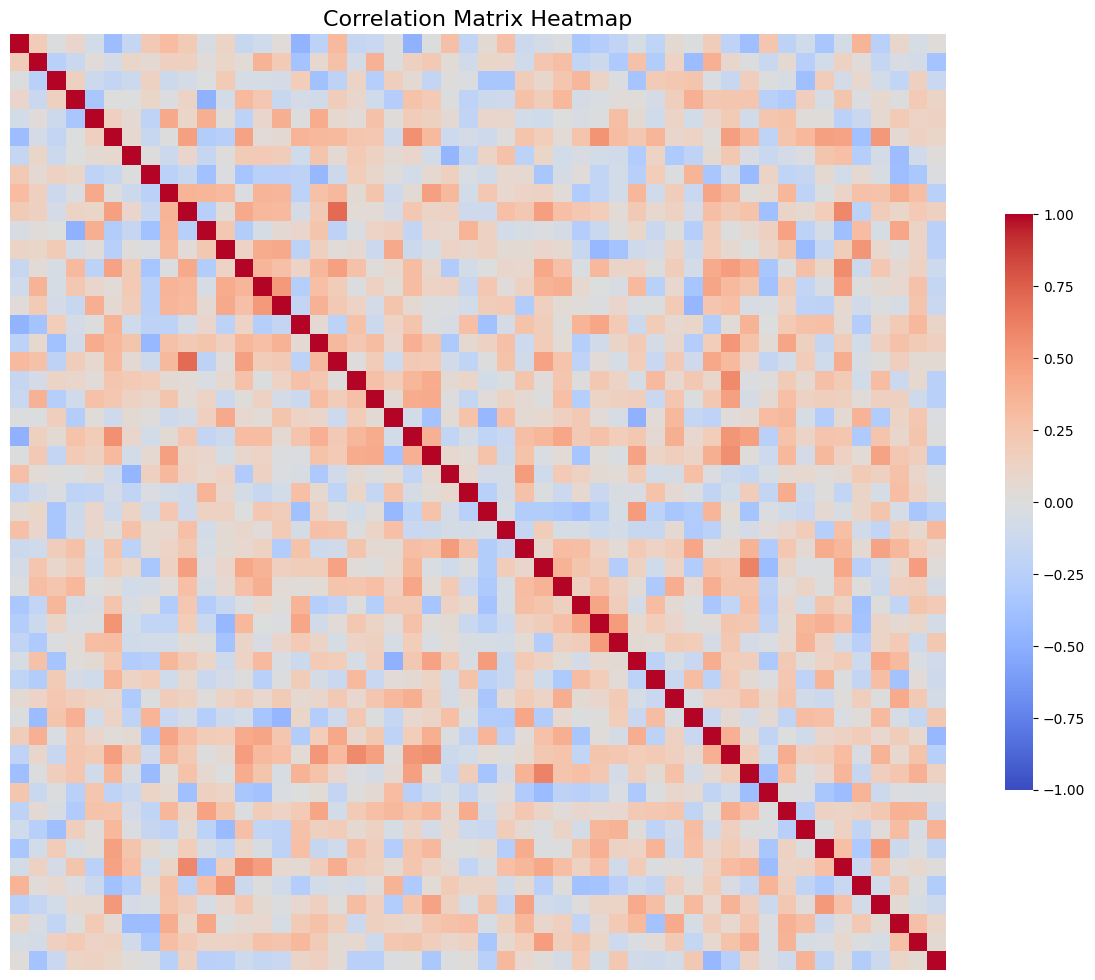

In [53]:
corr_matrix = compute_correlation_matrix(prcTest, True, 25)
plot_correlation_heatmap(corr_matrix)


In [12]:
top5 = get_top_correlated_pairs(corr_matrix, top_n=5)
for i, j, val in top5:
    print(f"Instrument {i} & Instrument {j} → Correlation: {val}")

Instrument 31 & Instrument 41 → Correlation: 0.1373
Instrument 32 & Instrument 45 → Correlation: 0.137
Instrument 3 & Instrument 48 → Correlation: 0.1339
Instrument 13 & Instrument 17 → Correlation: 0.1311
Instrument 7 & Instrument 38 → Correlation: 0.1283


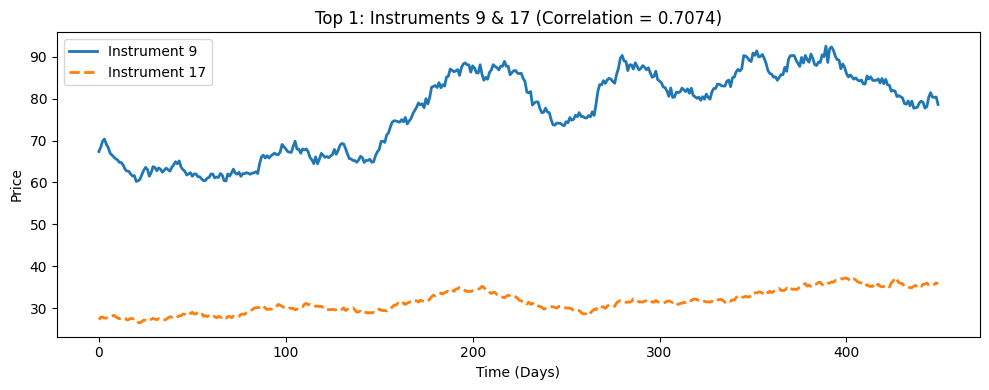

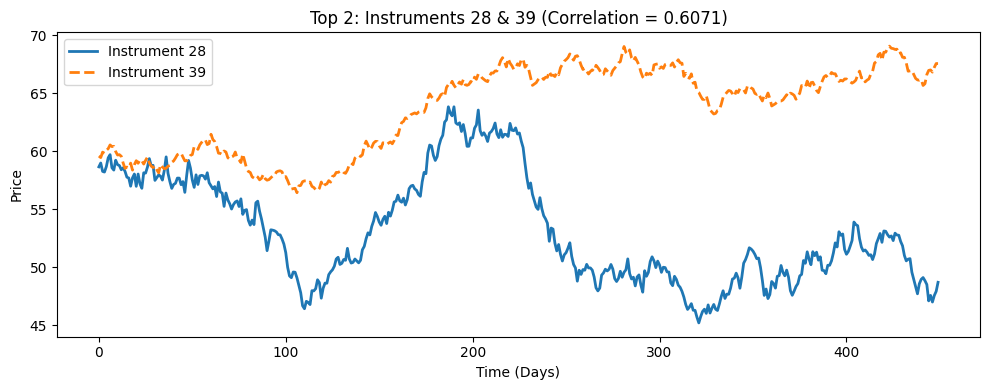

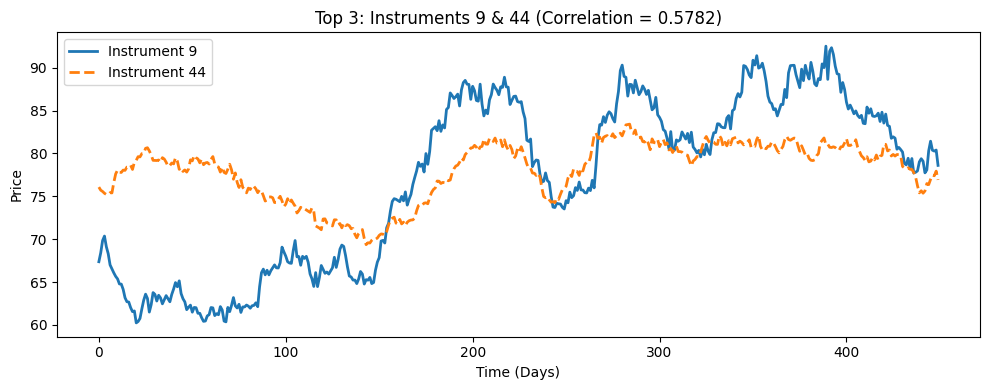

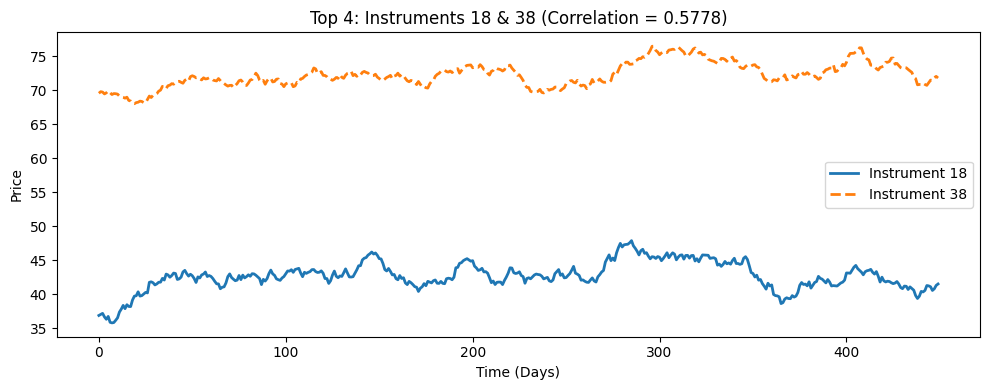

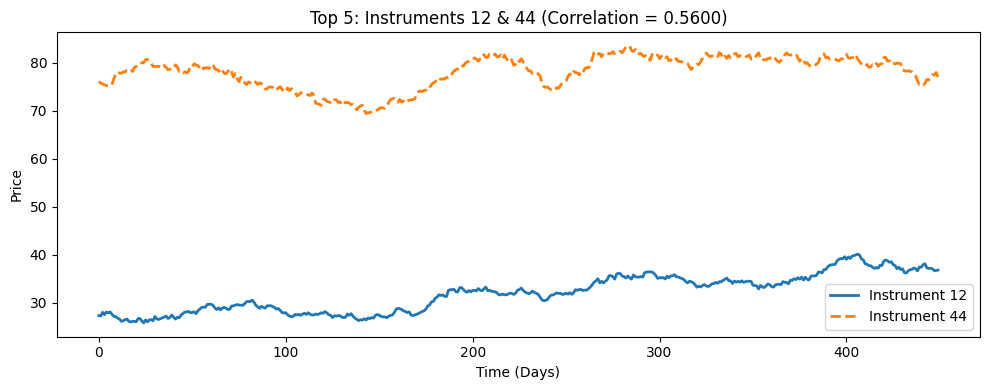

In [54]:
def plot_top_correlated_pairs(prc_matrix, corr_matrix, top_n=5, use_returns=False, smooth=False, smooth_window=5):
    """
    Plots the top N most correlated instrument pairs from a correlation matrix.

    Parameters:
        prc_matrix (ndarray): (instruments, time) closing price matrix
        corr_matrix (ndarray): (instruments, instruments) correlation matrix
        top_n (int): Number of top correlated pairs to plot
        use_returns (bool): If True, plot log returns instead of prices
        smooth (bool): Whether to apply moving average smoothing
        smooth_window (int): Window size for smoothing (in days)
    """
    # Step 1: Get top correlated index pairs
    n = corr_matrix.shape[0]
    upper = np.triu_indices(n, k=1)
    corr_values = corr_matrix[upper]
    index_pairs = list(zip(upper[0], upper[1]))
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)
    top_pairs = sorted_pairs[:top_n]

    # Step 2: Compute returns or use prices
    if use_returns:
        log_prices = np.log(prc_matrix)
        data = np.diff(log_prices, axis=1)
        ylabel = "Log Returns"
    else:
        data = prc_matrix
        ylabel = "Price"

    # Step 3: Optional smoothing
    if smooth:
        # Apply moving average across time axis (axis=1)
        kernel = np.ones(smooth_window) / smooth_window
        data = np.array([
            np.convolve(row, kernel, mode='valid')
            for row in data
        ])
        xlabel = f"Time (Days) [Smoothed, Window={smooth_window}]"
    else:
        xlabel = "Time (Days)"

    # Step 4: Plot each pair
    for idx, ((i, j), corr_val) in enumerate(top_pairs, 1):
        plt.figure(figsize=(10, 4))
        plt.plot(data[i], label=f"Instrument {i}", linewidth=2)
        plt.plot(data[j], label=f"Instrument {j}", linewidth=2, linestyle='--')
        plt.title(f"Top {idx}: Instruments {i} & {j} (Correlation = {corr_val:.4f})")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_top_correlated_pairs(prcTest, corr_matrix, 5, False)

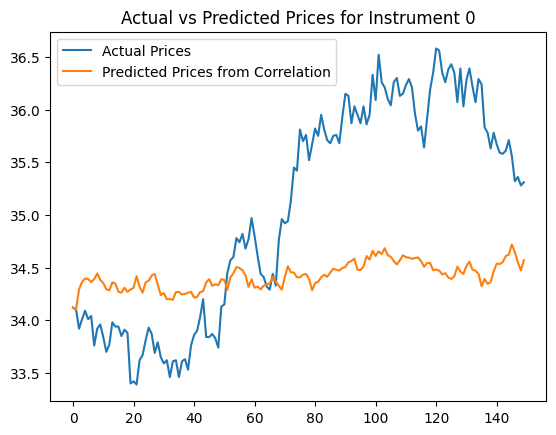

Evaluation for Instrument 0:
Mean Squared Error (MSE): 0.000026
Mean Absolute Error (MAE): 0.003986
R² Score: -0.0970


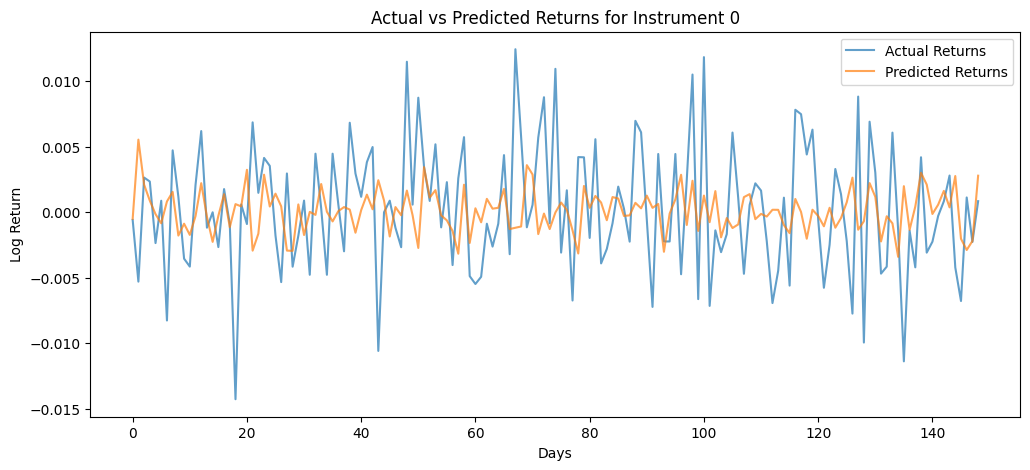

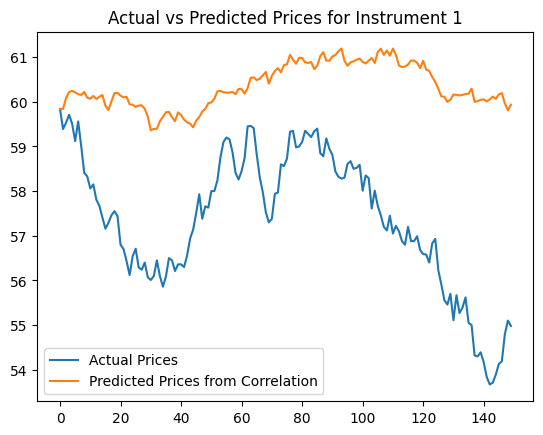

Evaluation for Instrument 1:
Mean Squared Error (MSE): 0.000033
Mean Absolute Error (MAE): 0.004645
R² Score: -0.1134


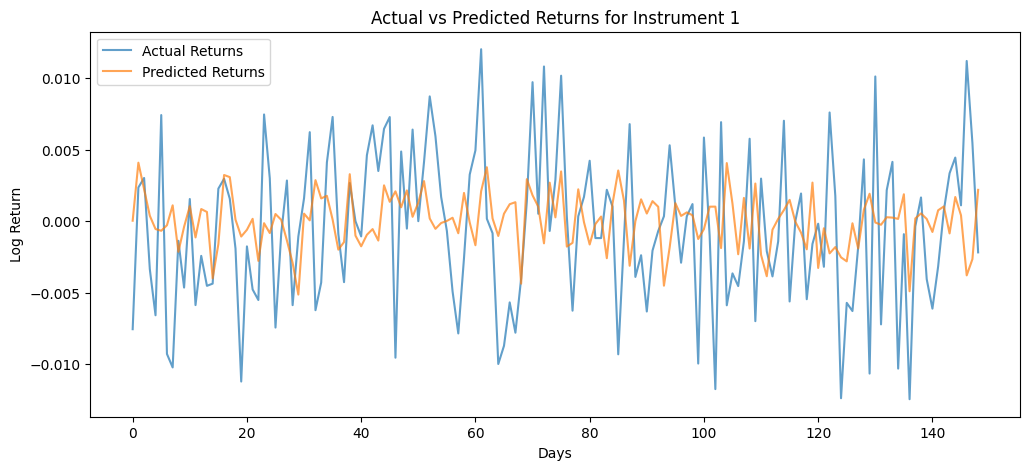

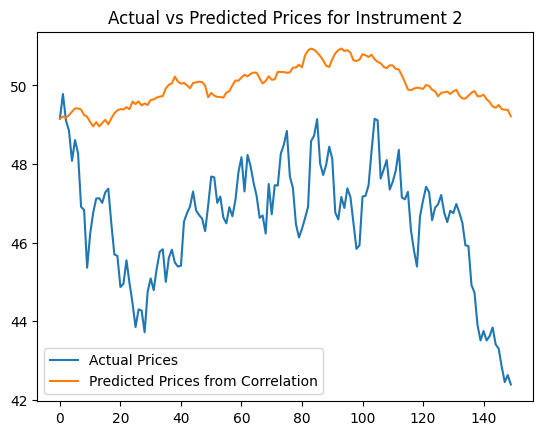

Evaluation for Instrument 2:
Mean Squared Error (MSE): 0.000157
Mean Absolute Error (MAE): 0.010052
R² Score: -0.0180


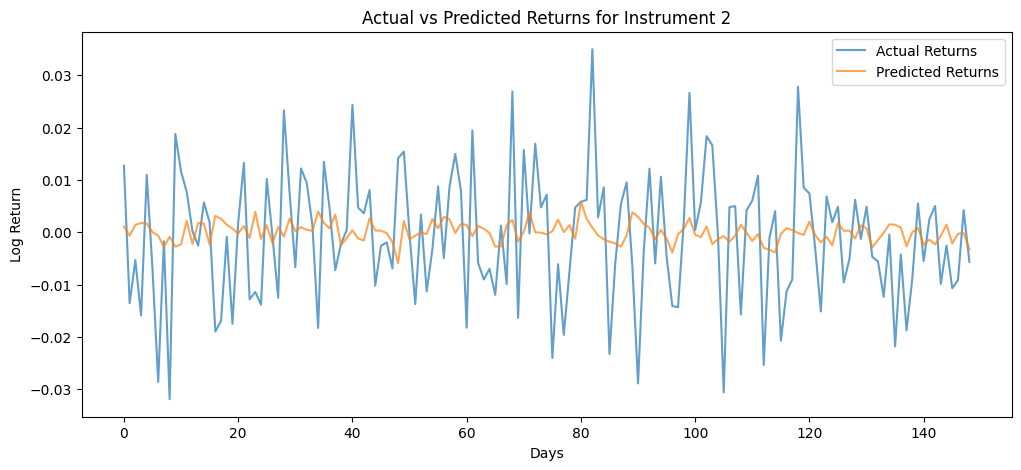

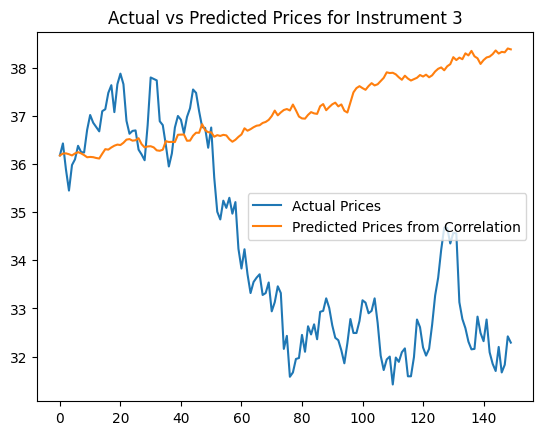

Evaluation for Instrument 3:
Mean Squared Error (MSE): 0.000151
Mean Absolute Error (MAE): 0.009744
R² Score: -0.0333


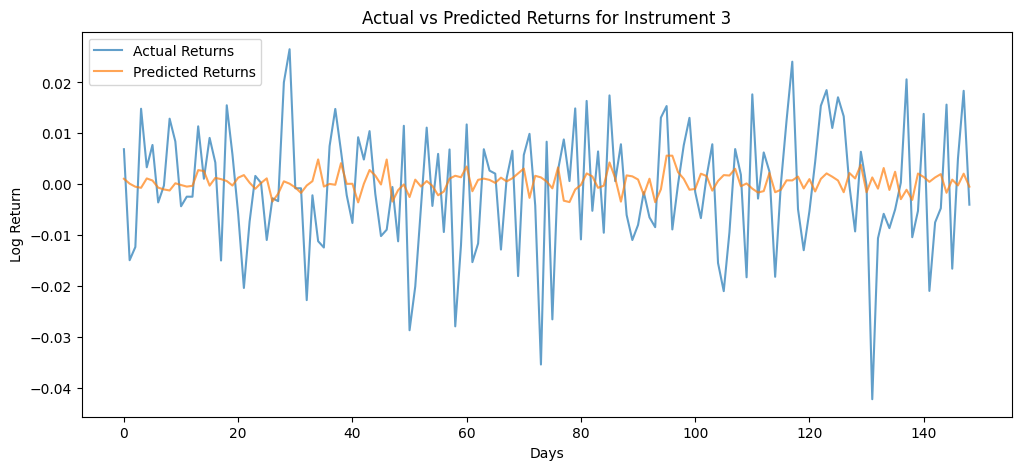

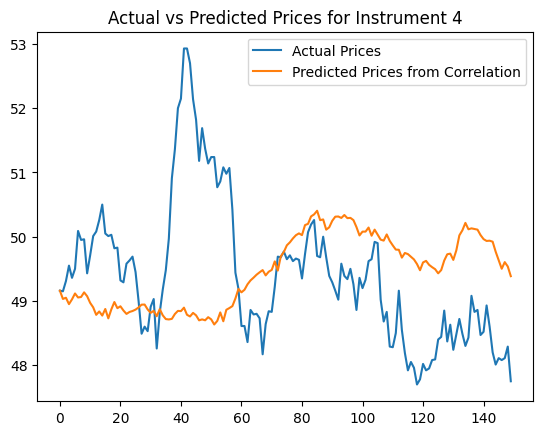

Evaluation for Instrument 4:
Mean Squared Error (MSE): 0.000049
Mean Absolute Error (MAE): 0.005588
R² Score: -0.0367


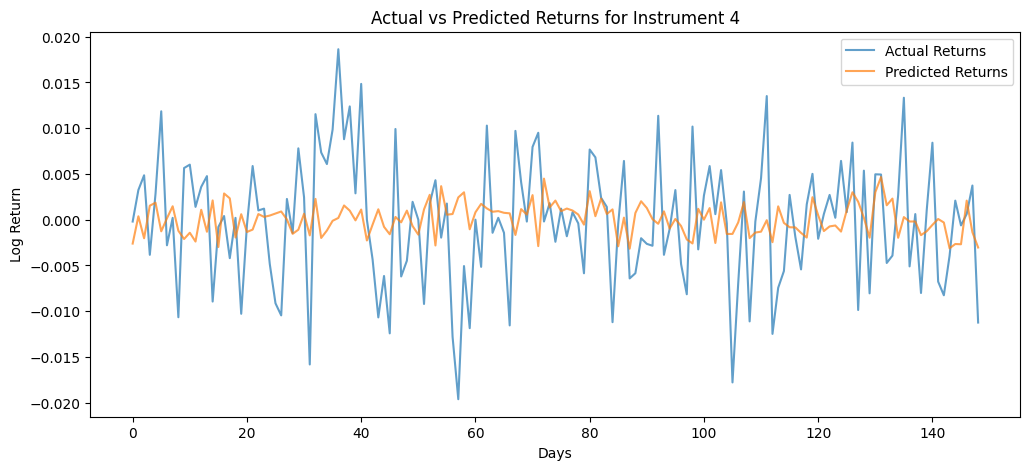

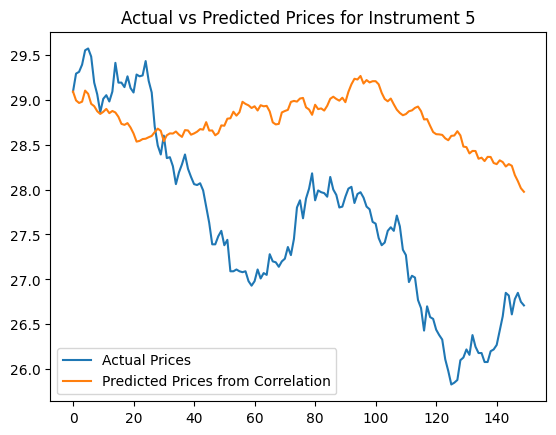

Evaluation for Instrument 5:
Mean Squared Error (MSE): 0.000030
Mean Absolute Error (MAE): 0.004232
R² Score: -0.1810


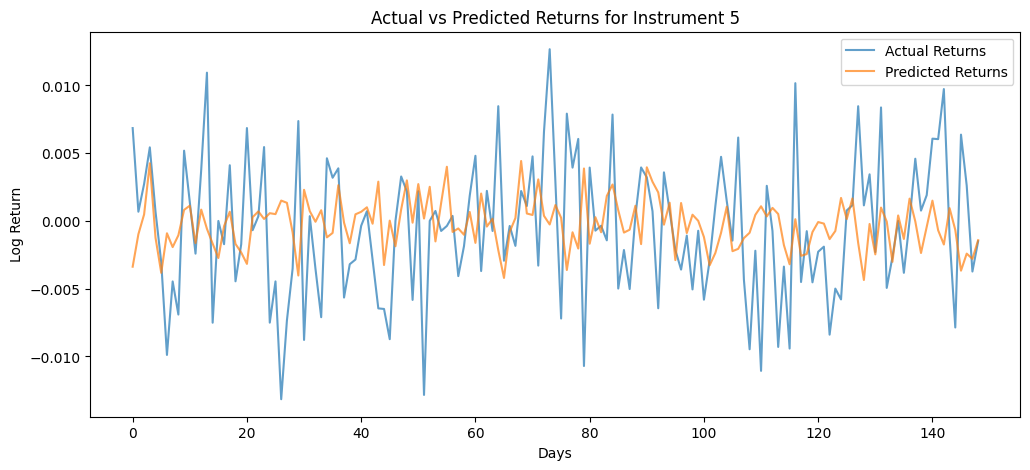

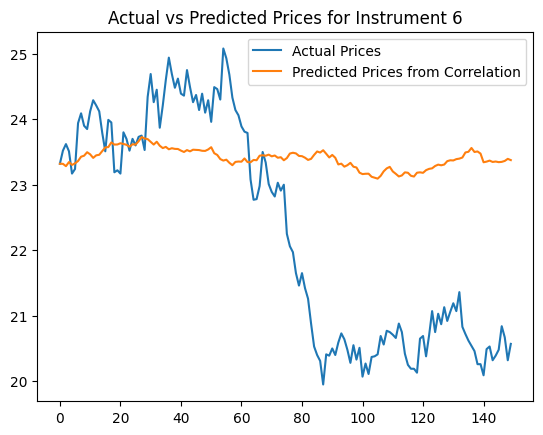

Evaluation for Instrument 6:
Mean Squared Error (MSE): 0.000161
Mean Absolute Error (MAE): 0.010211
R² Score: -0.0513


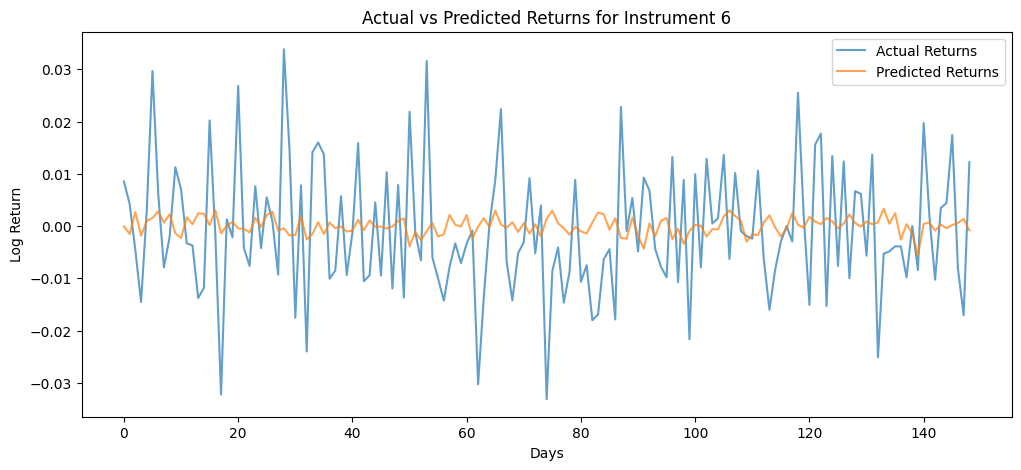

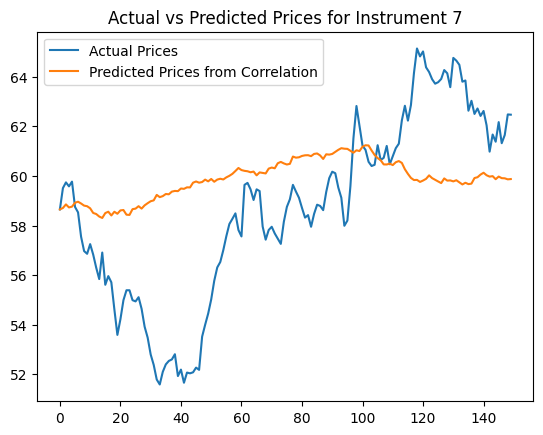

Evaluation for Instrument 7:
Mean Squared Error (MSE): 0.000115
Mean Absolute Error (MAE): 0.008293
R² Score: -0.0389


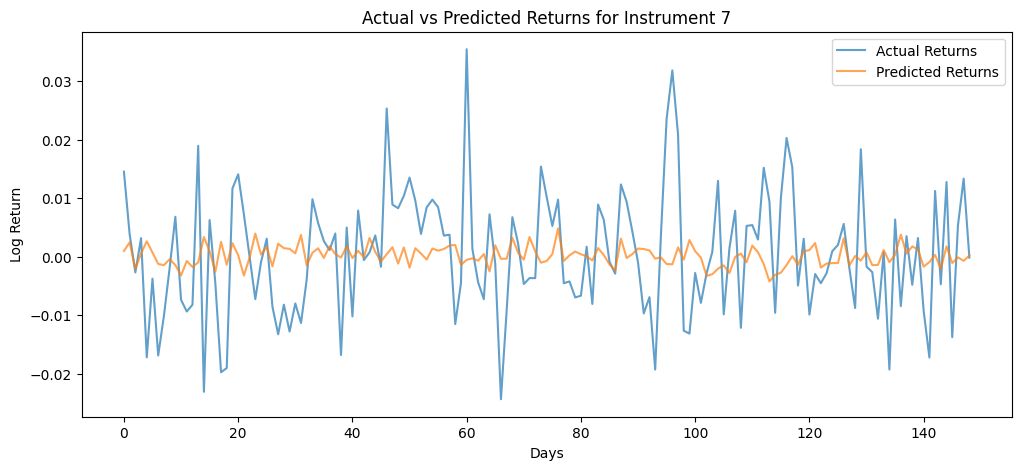

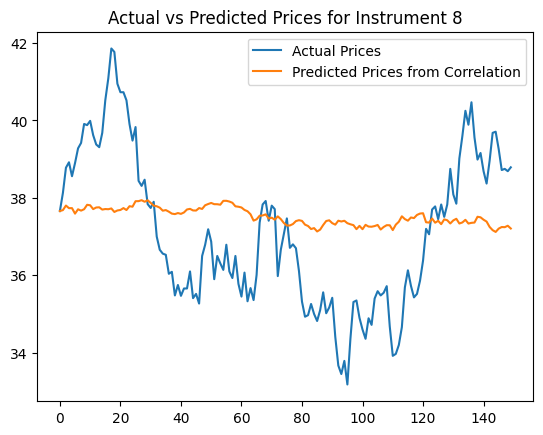

Evaluation for Instrument 8:
Mean Squared Error (MSE): 0.000220
Mean Absolute Error (MAE): 0.011852
R² Score: -0.0393


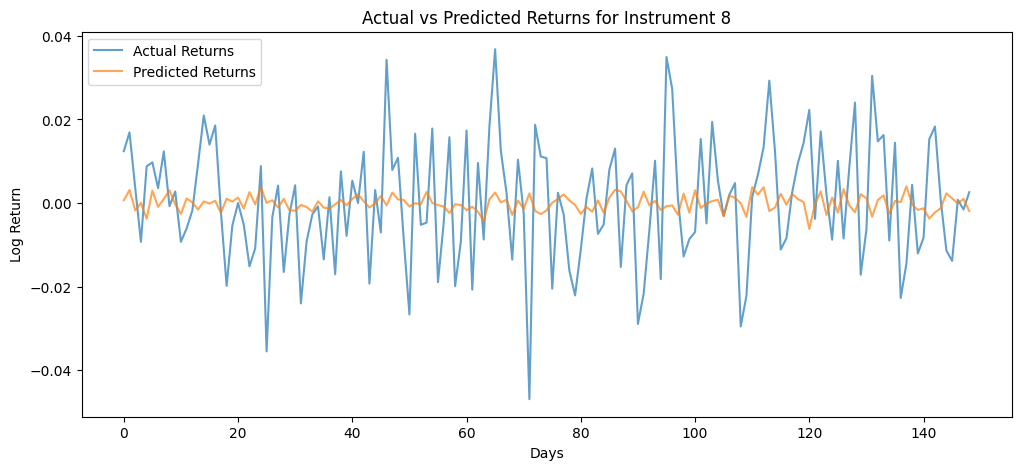

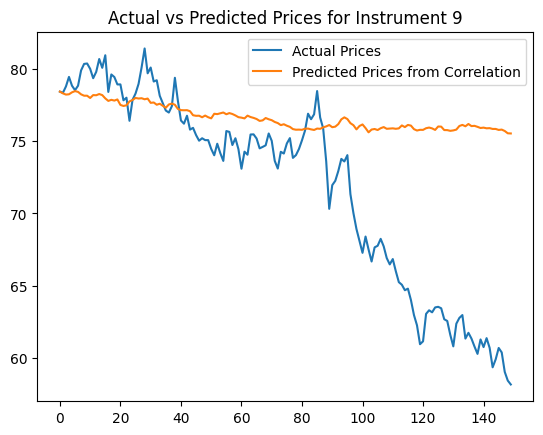

Evaluation for Instrument 9:
Mean Squared Error (MSE): 0.000168
Mean Absolute Error (MAE): 0.010328
R² Score: -0.0116


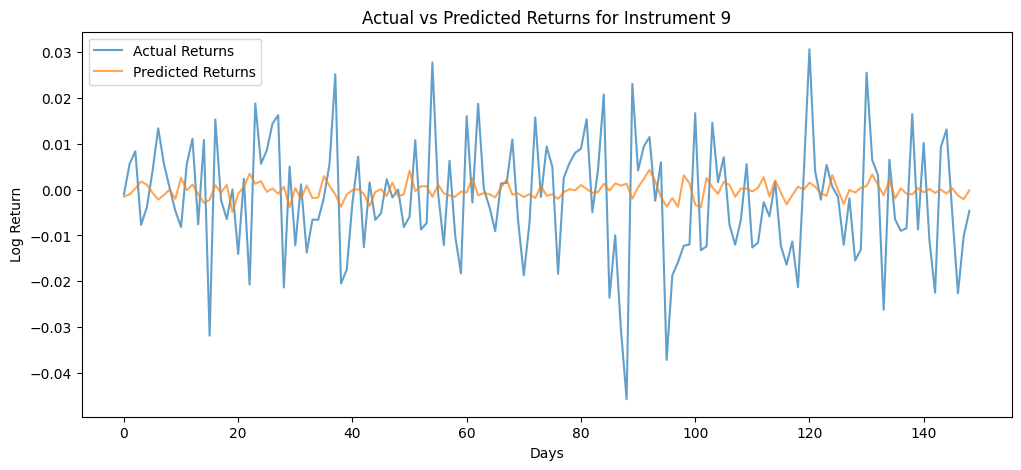

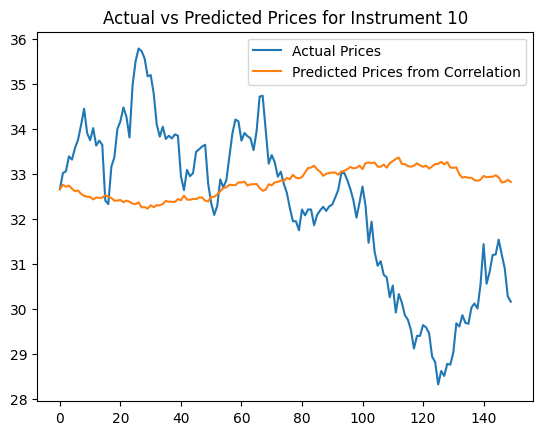

Evaluation for Instrument 10:
Mean Squared Error (MSE): 0.000145
Mean Absolute Error (MAE): 0.009436
R² Score: -0.0590


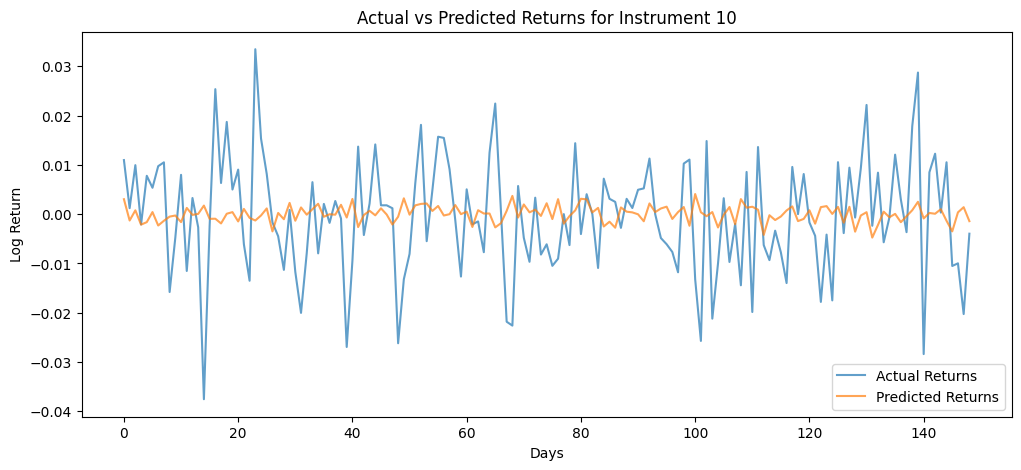

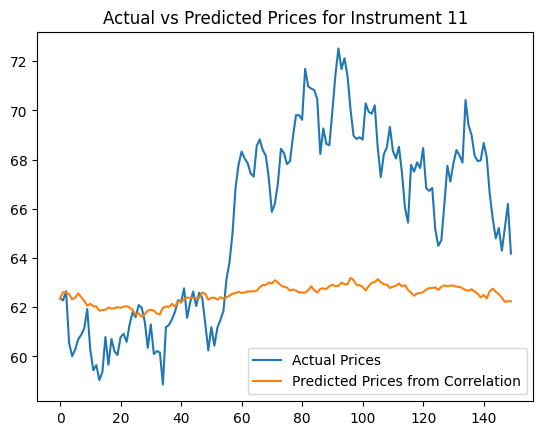

Evaluation for Instrument 11:
Mean Squared Error (MSE): 0.000204
Mean Absolute Error (MAE): 0.011243
R² Score: -0.0428


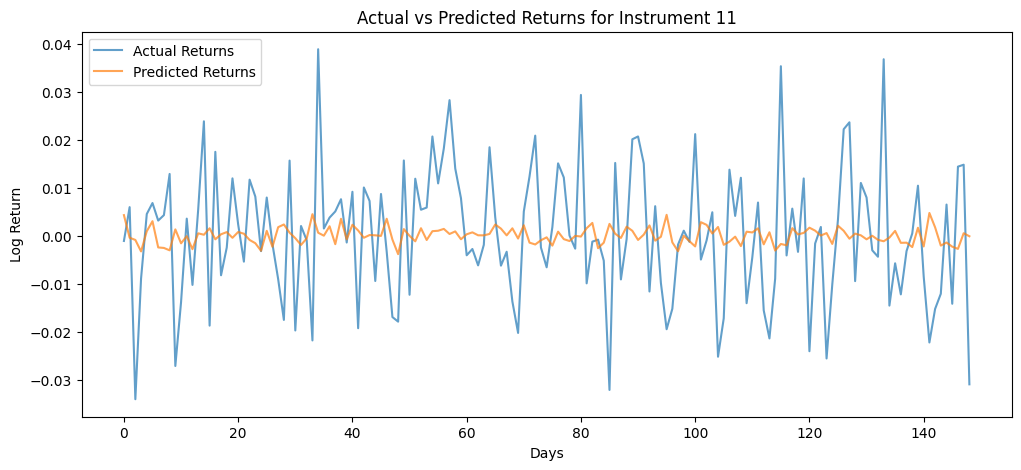

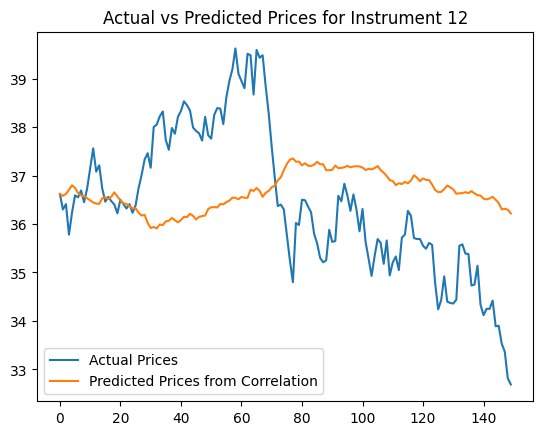

Evaluation for Instrument 12:
Mean Squared Error (MSE): 0.000123
Mean Absolute Error (MAE): 0.008704
R² Score: -0.0609


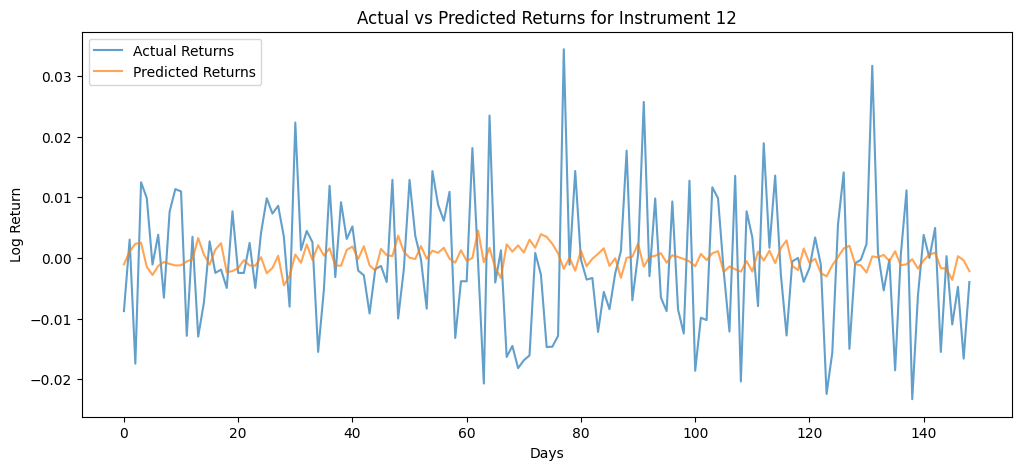

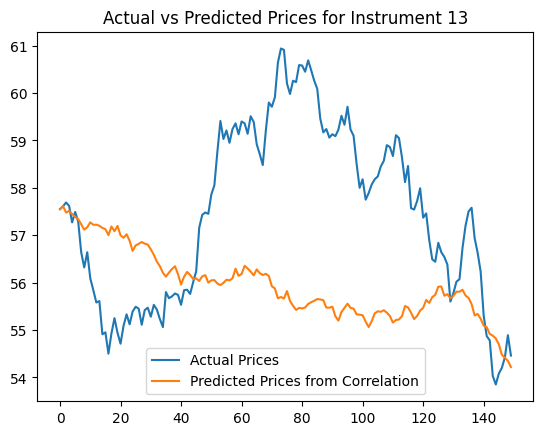

Evaluation for Instrument 13:
Mean Squared Error (MSE): 0.000039
Mean Absolute Error (MAE): 0.004829
R² Score: -0.0114


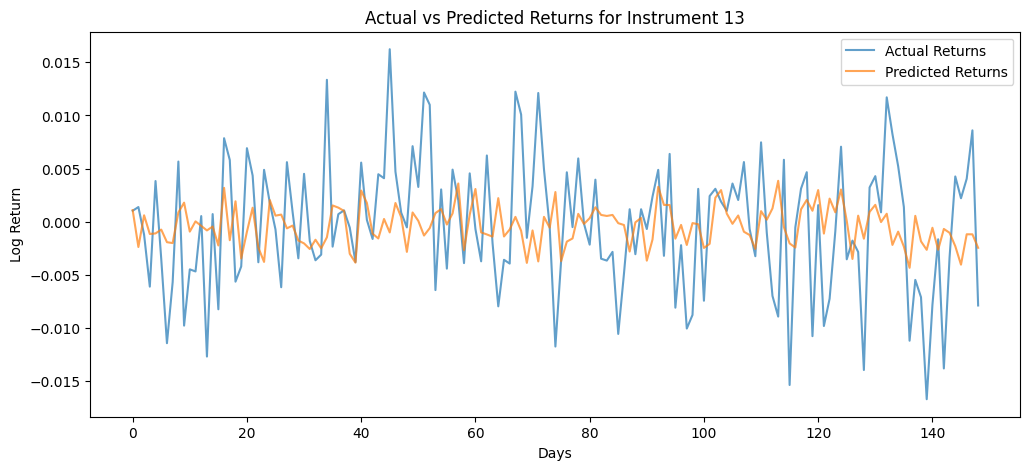

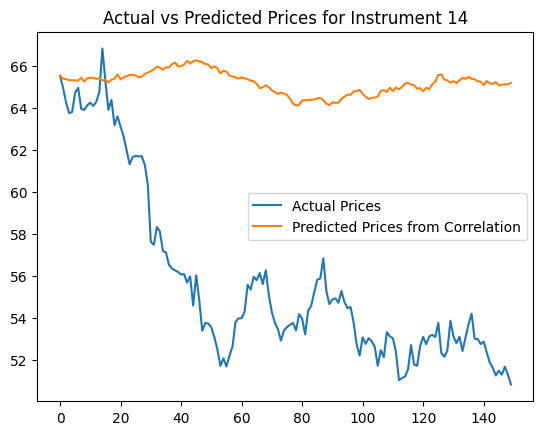

Evaluation for Instrument 14:
Mean Squared Error (MSE): 0.000158
Mean Absolute Error (MAE): 0.009718
R² Score: -0.0466


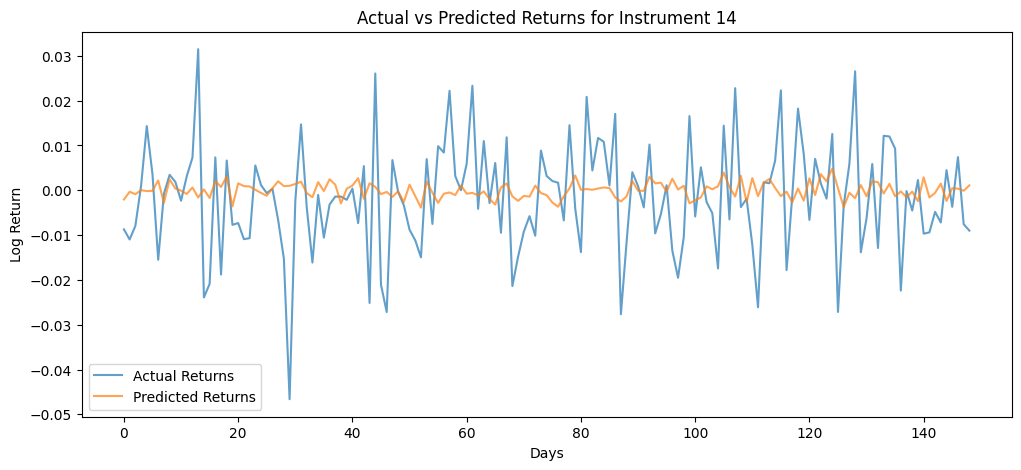

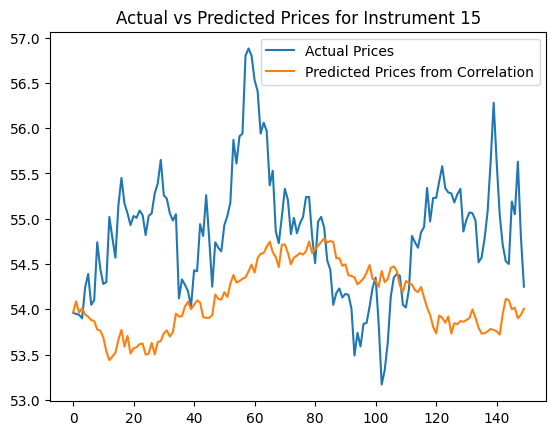

Evaluation for Instrument 15:
Mean Squared Error (MSE): 0.000036
Mean Absolute Error (MAE): 0.004549
R² Score: -0.0458


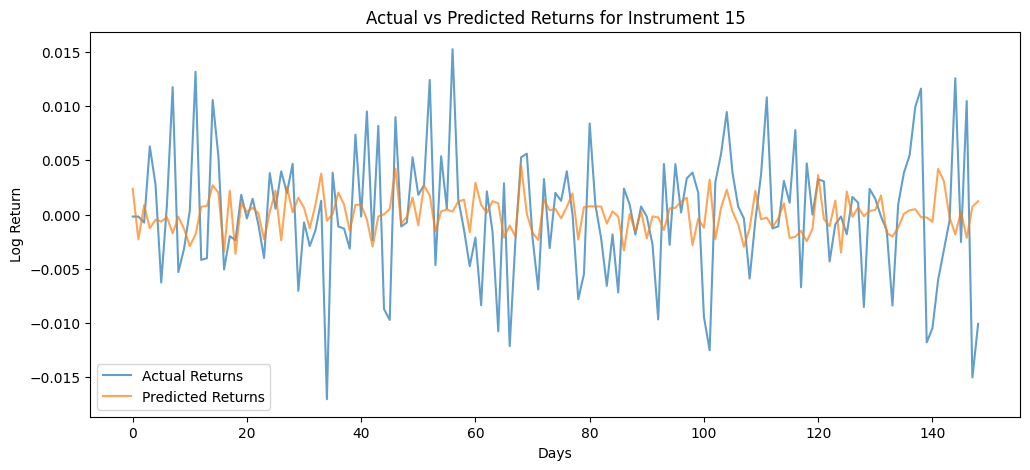

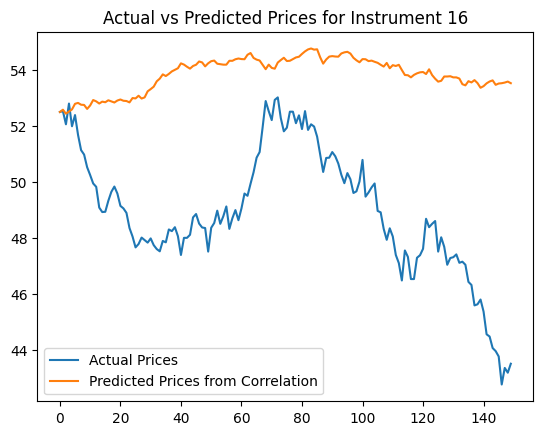

Evaluation for Instrument 16:
Mean Squared Error (MSE): 0.000097
Mean Absolute Error (MAE): 0.008031
R² Score: -0.0968


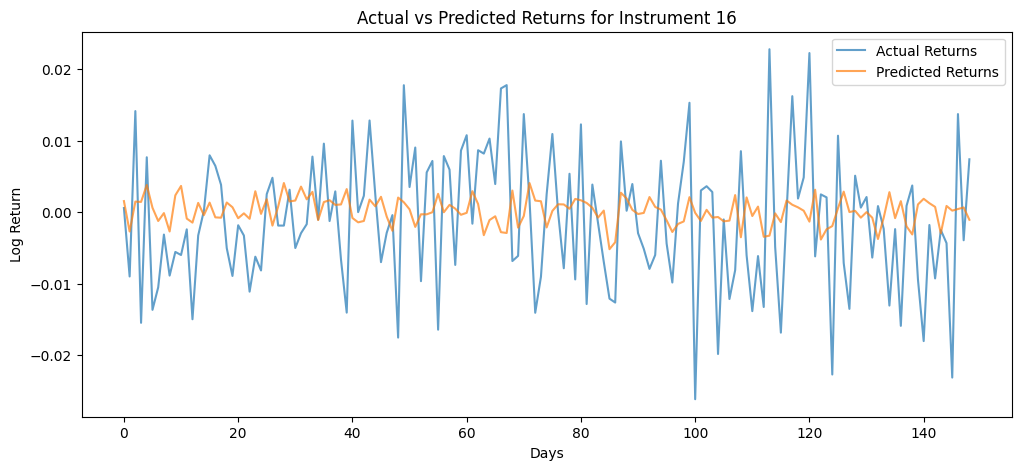

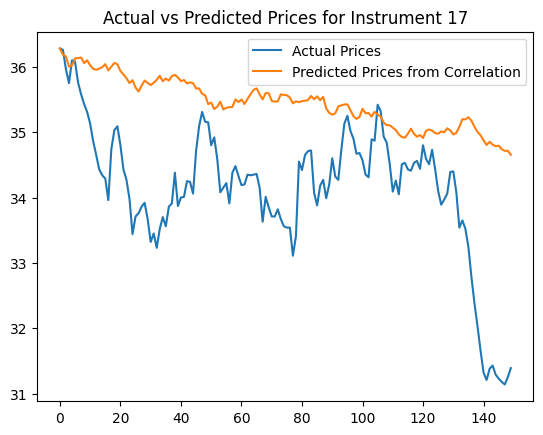

Evaluation for Instrument 17:
Mean Squared Error (MSE): 0.000067
Mean Absolute Error (MAE): 0.006353
R² Score: -0.0039


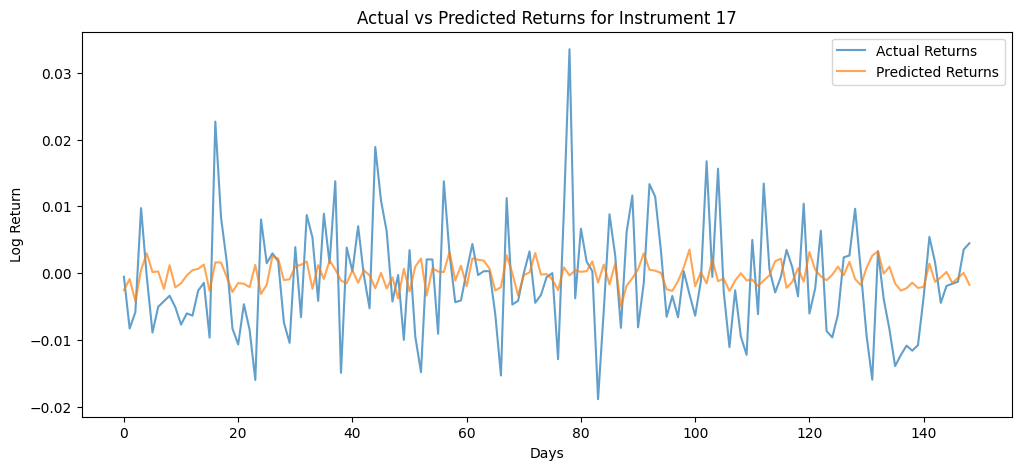

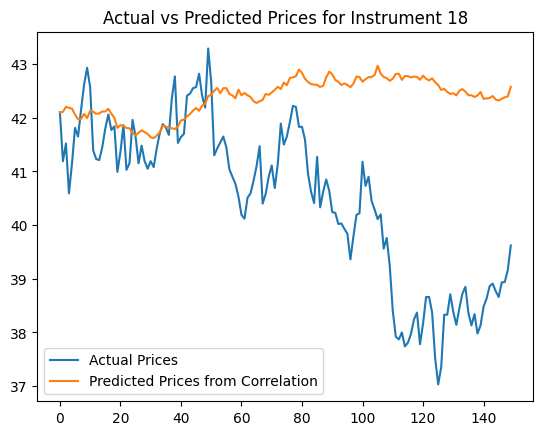

Evaluation for Instrument 18:
Mean Squared Error (MSE): 0.000118
Mean Absolute Error (MAE): 0.008385
R² Score: 0.0021


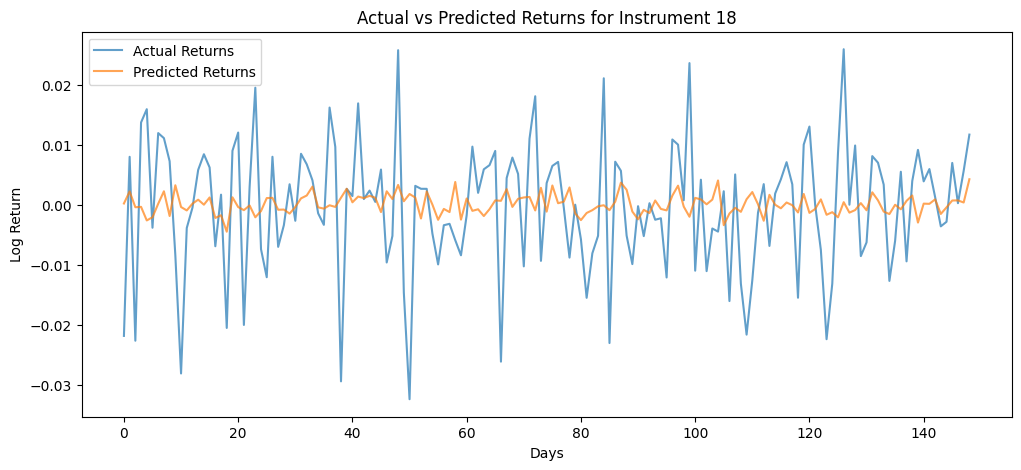

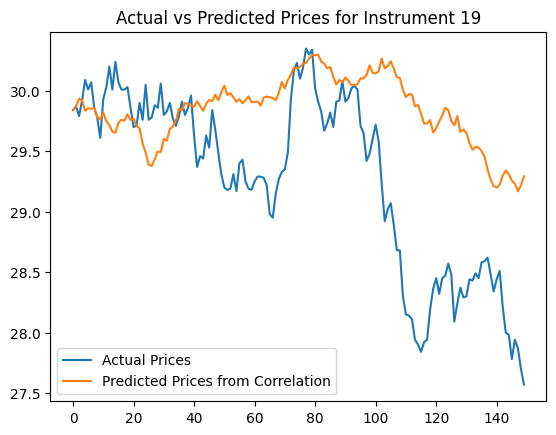

Evaluation for Instrument 19:
Mean Squared Error (MSE): 0.000031
Mean Absolute Error (MAE): 0.004392
R² Score: -0.1081


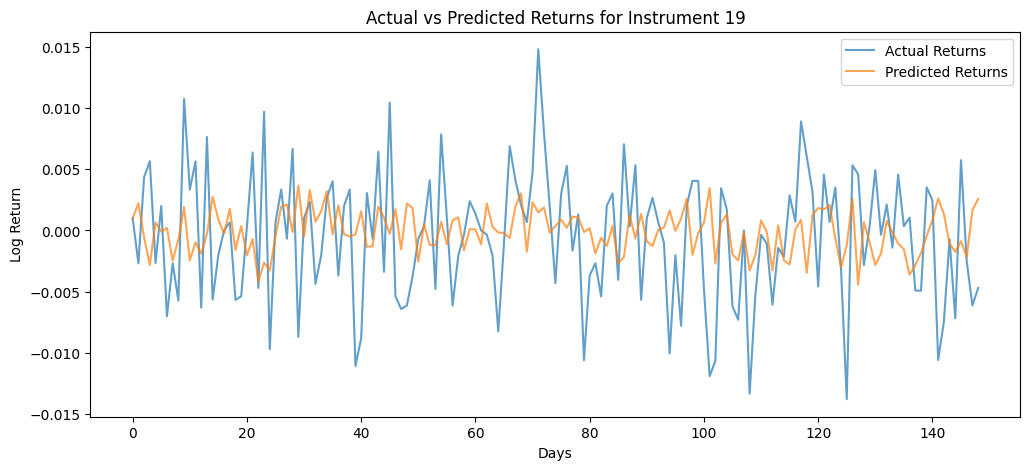

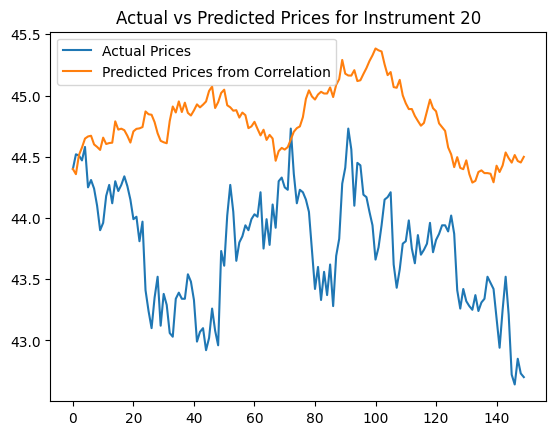

Evaluation for Instrument 20:
Mean Squared Error (MSE): 0.000028
Mean Absolute Error (MAE): 0.004168
R² Score: -0.0870


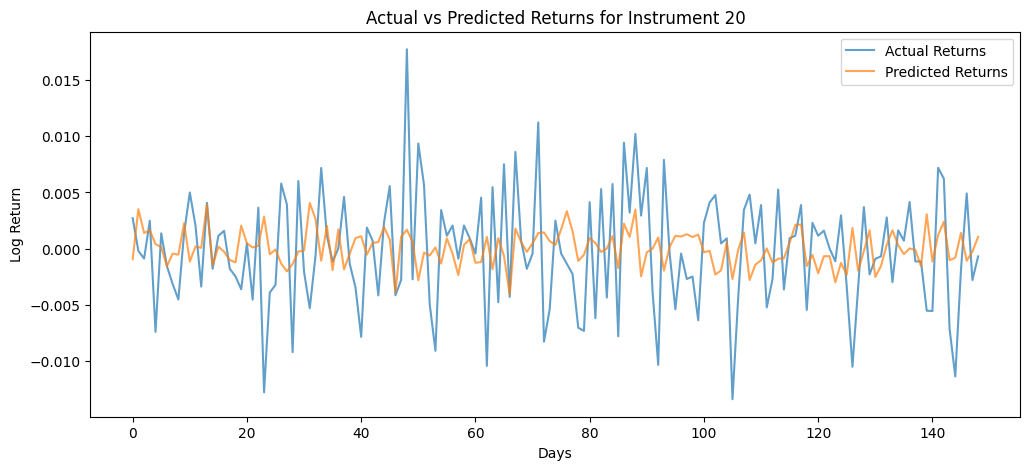

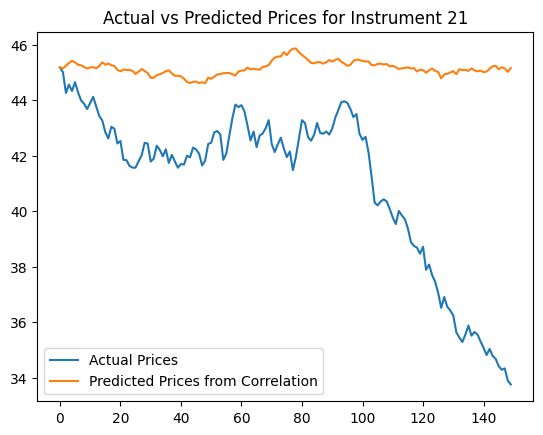

Evaluation for Instrument 21:
Mean Squared Error (MSE): 0.000076
Mean Absolute Error (MAE): 0.007099
R² Score: -0.0598


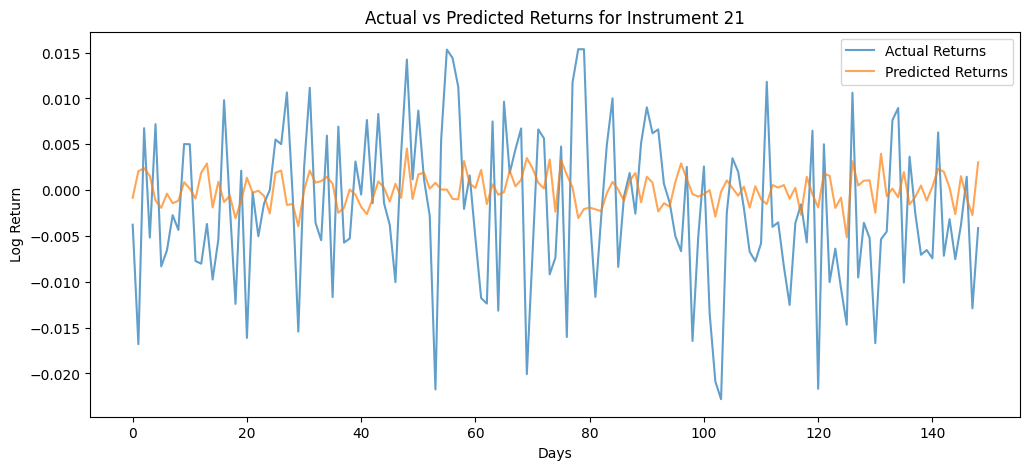

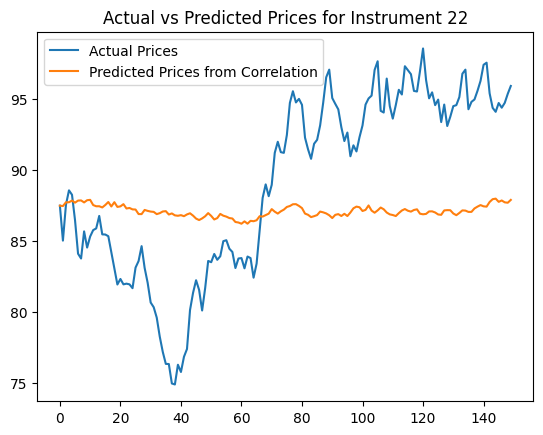

Evaluation for Instrument 22:
Mean Squared Error (MSE): 0.000182
Mean Absolute Error (MAE): 0.010999
R² Score: -0.0219


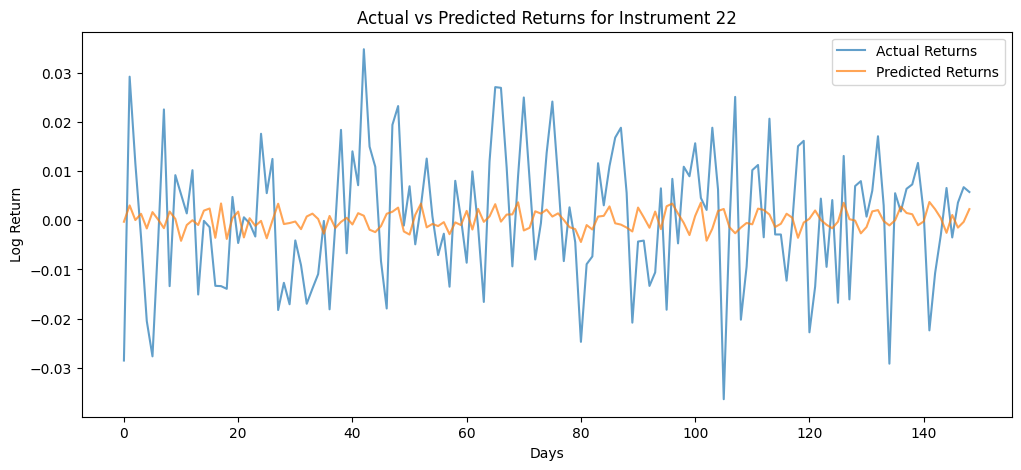

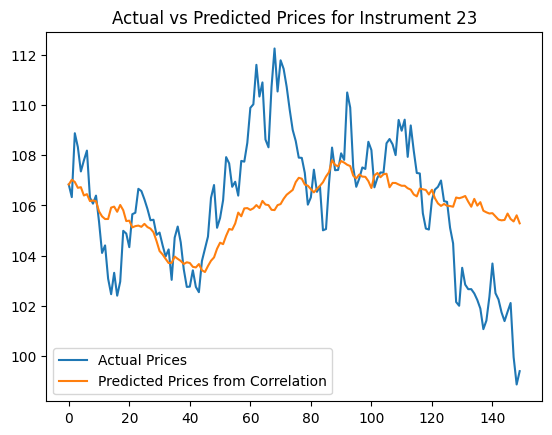

Evaluation for Instrument 23:
Mean Squared Error (MSE): 0.000088
Mean Absolute Error (MAE): 0.007383
R² Score: -0.0341


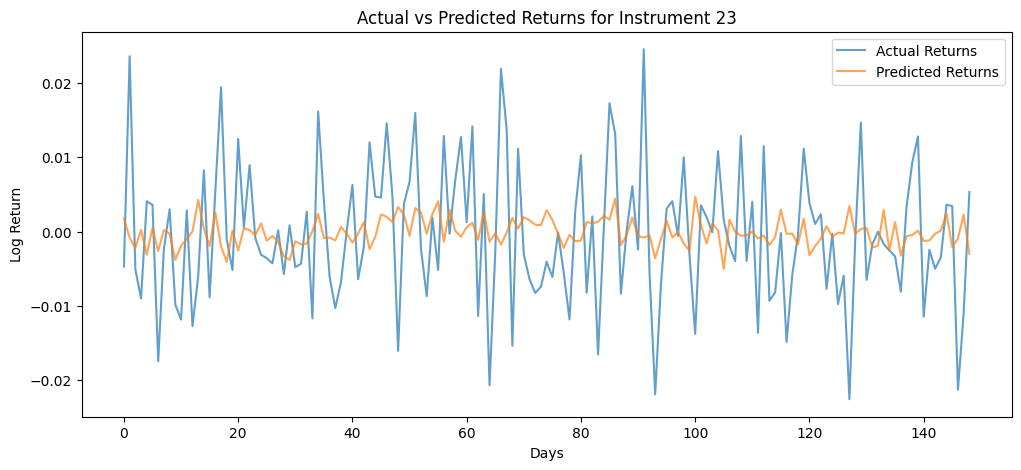

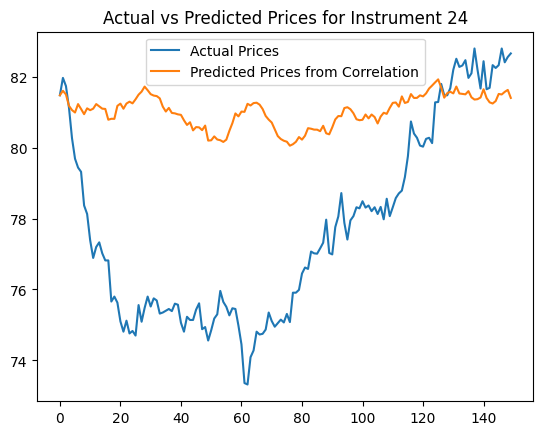

Evaluation for Instrument 24:
Mean Squared Error (MSE): 0.000029
Mean Absolute Error (MAE): 0.004249
R² Score: -0.0267


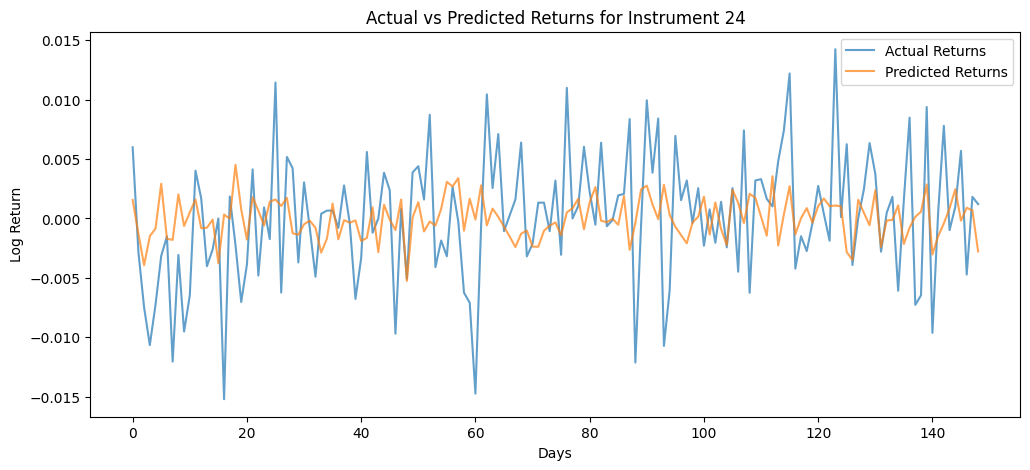

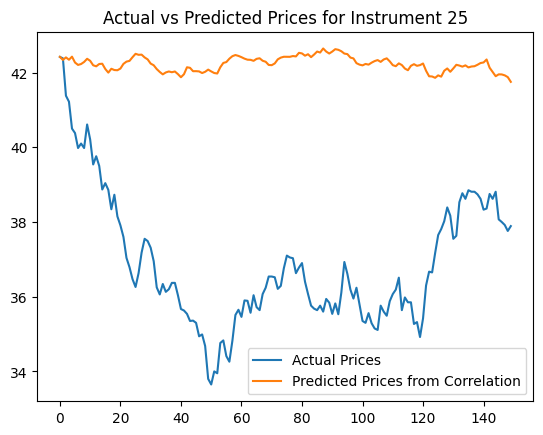

Evaluation for Instrument 25:
Mean Squared Error (MSE): 0.000107
Mean Absolute Error (MAE): 0.008248
R² Score: -0.0854


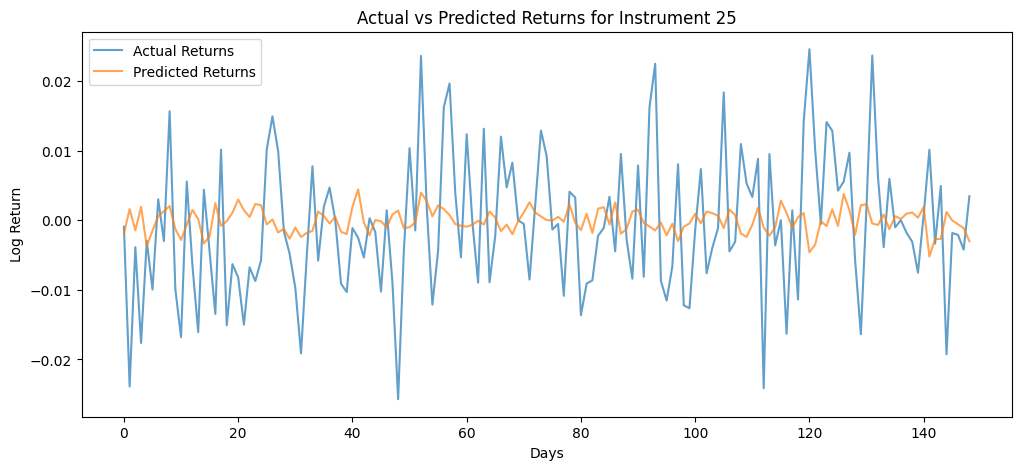

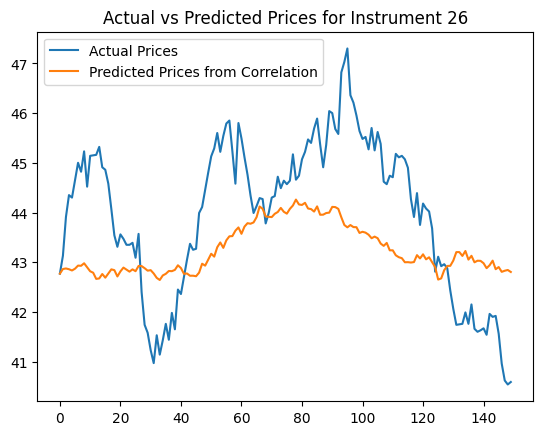

Evaluation for Instrument 26:
Mean Squared Error (MSE): 0.000080
Mean Absolute Error (MAE): 0.007002
R² Score: -0.0064


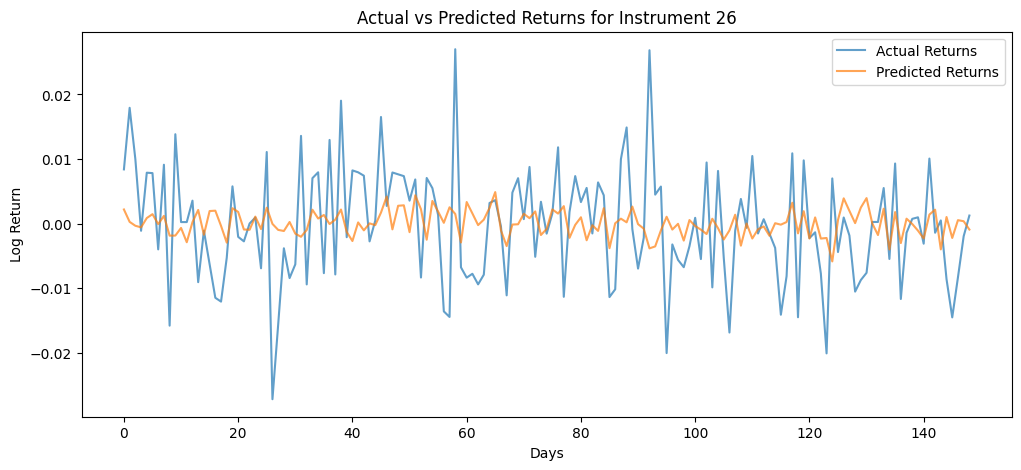

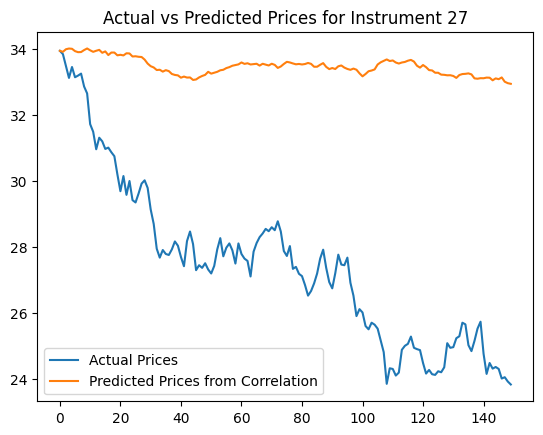

Evaluation for Instrument 27:
Mean Squared Error (MSE): 0.000177
Mean Absolute Error (MAE): 0.010642
R² Score: -0.0447


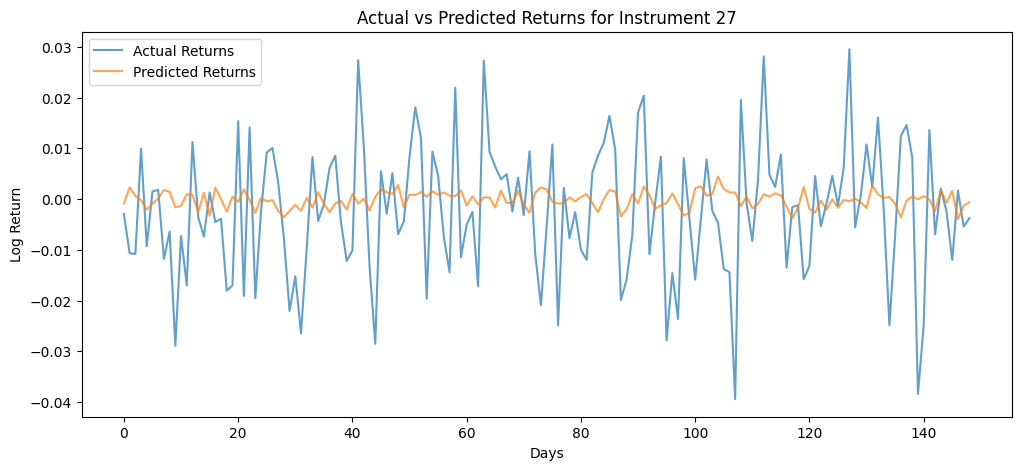

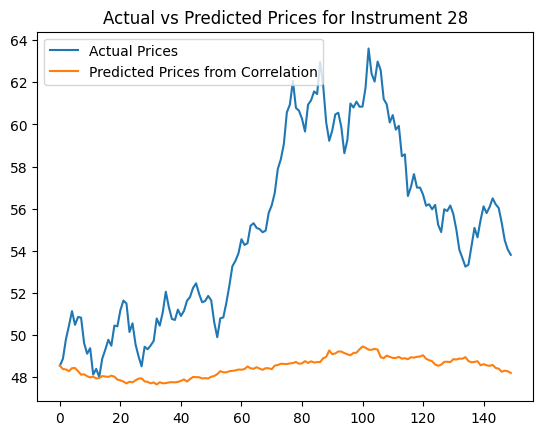

Evaluation for Instrument 28:
Mean Squared Error (MSE): 0.000171
Mean Absolute Error (MAE): 0.010682
R² Score: -0.0622


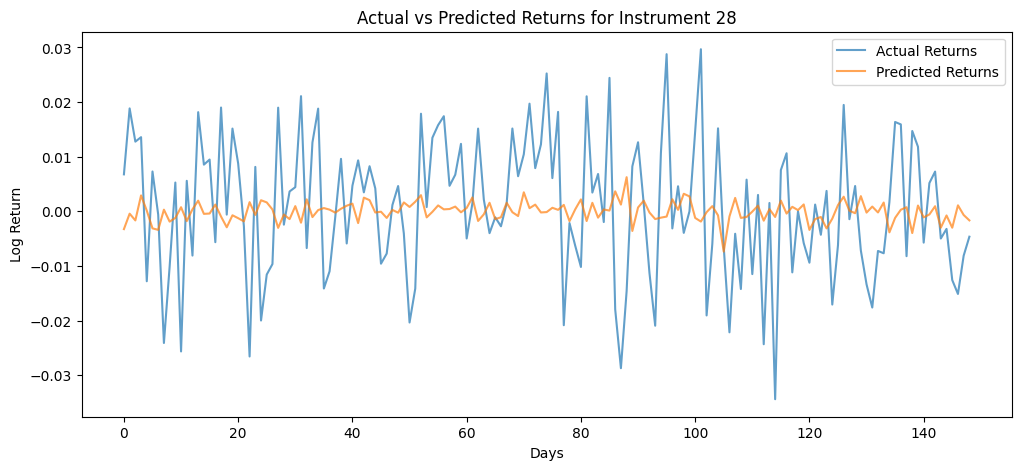

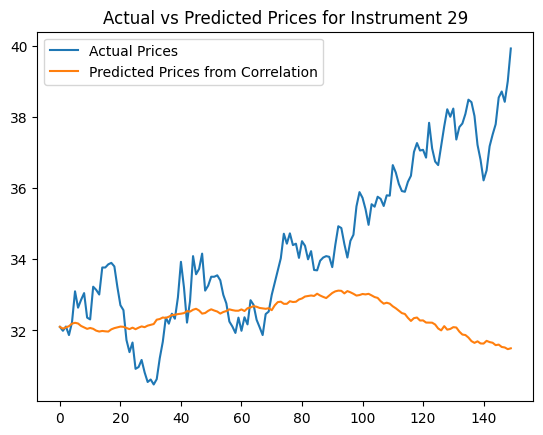

Evaluation for Instrument 29:
Mean Squared Error (MSE): 0.000172
Mean Absolute Error (MAE): 0.010533
R² Score: -0.0268


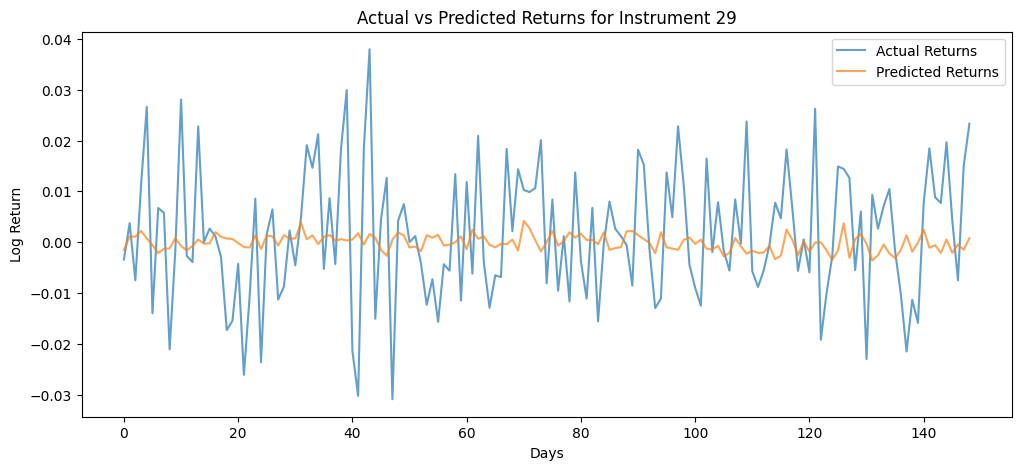

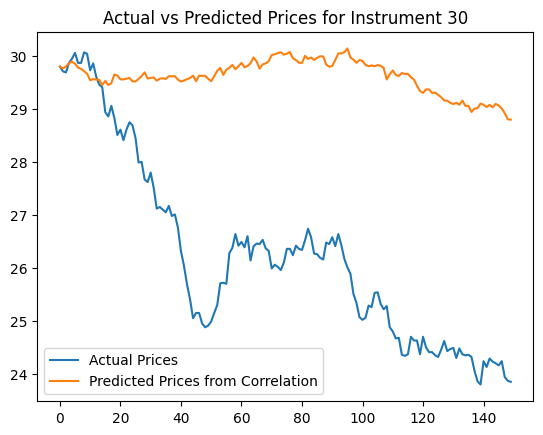

Evaluation for Instrument 30:
Mean Squared Error (MSE): 0.000064
Mean Absolute Error (MAE): 0.006154
R² Score: -0.1596


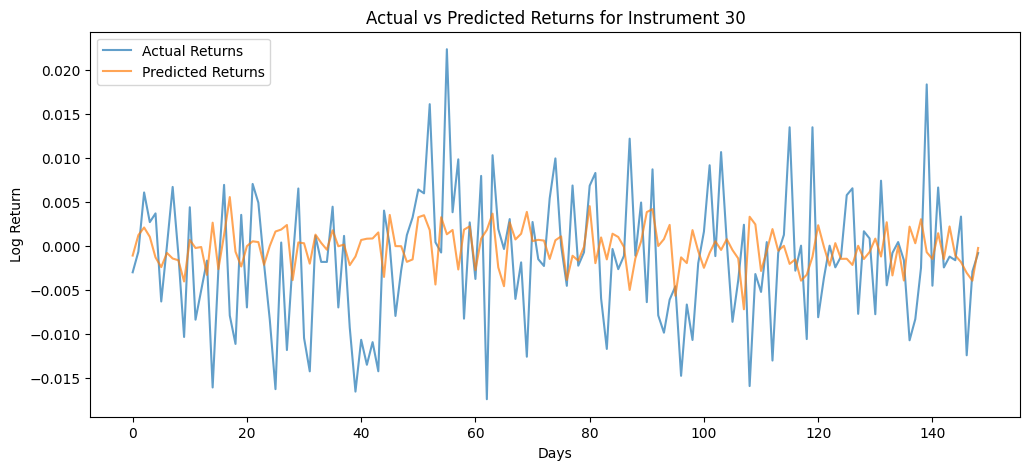

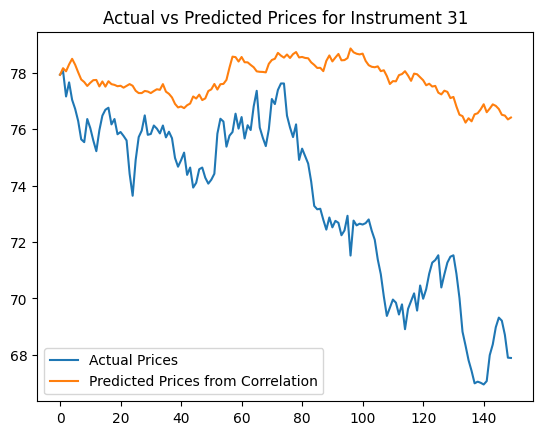

Evaluation for Instrument 31:
Mean Squared Error (MSE): 0.000059
Mean Absolute Error (MAE): 0.005994
R² Score: -0.0422


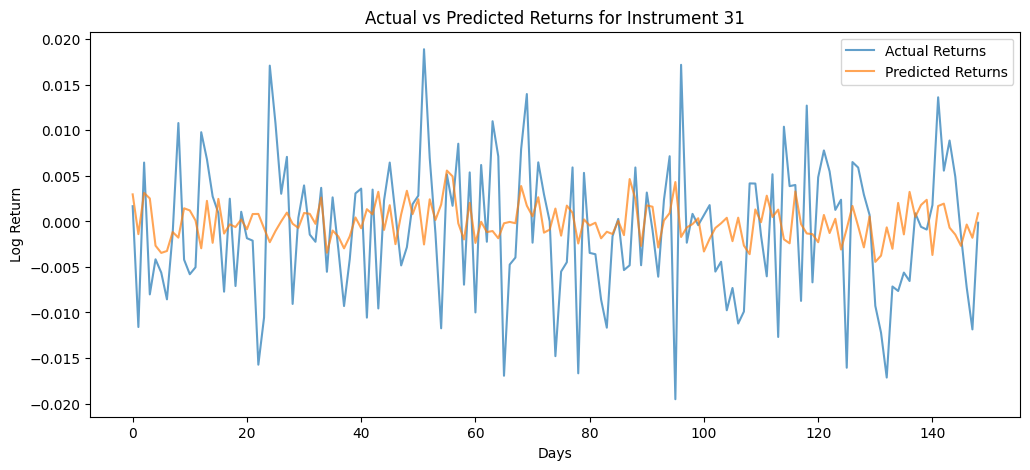

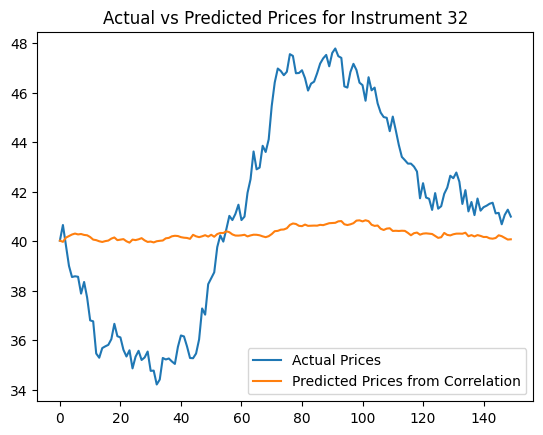

Evaluation for Instrument 32:
Mean Squared Error (MSE): 0.000159
Mean Absolute Error (MAE): 0.010078
R² Score: 0.0143


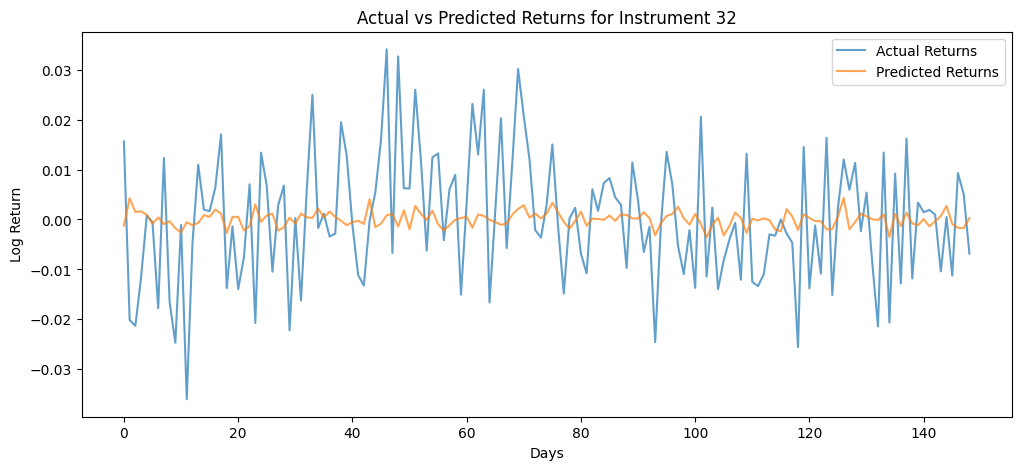

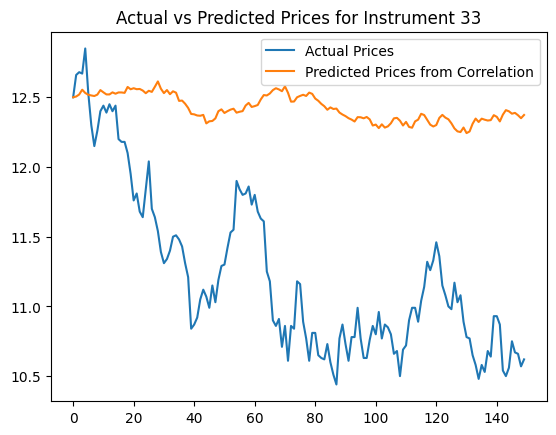

Evaluation for Instrument 33:
Mean Squared Error (MSE): 0.000168
Mean Absolute Error (MAE): 0.010275
R² Score: -0.0483


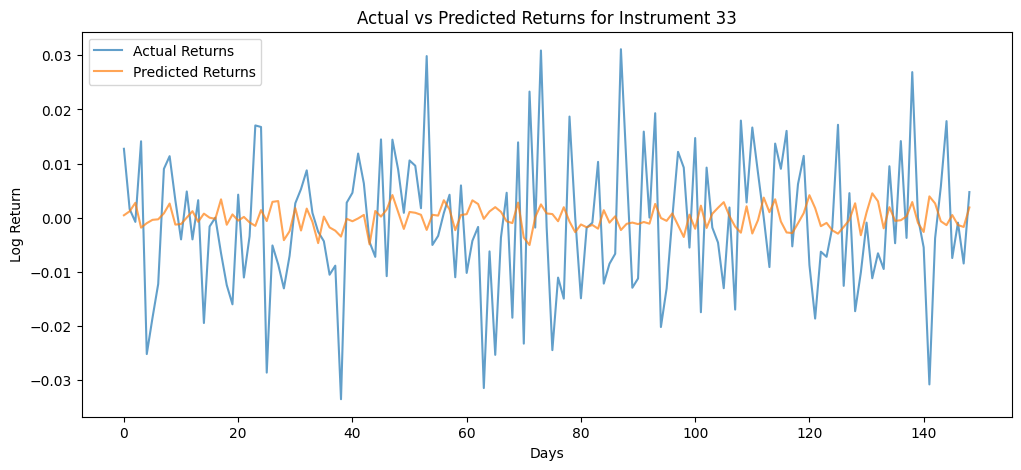

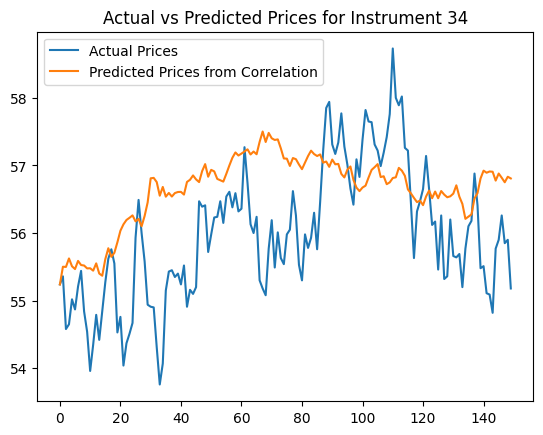

Evaluation for Instrument 34:
Mean Squared Error (MSE): 0.000077
Mean Absolute Error (MAE): 0.007032
R² Score: -0.0401


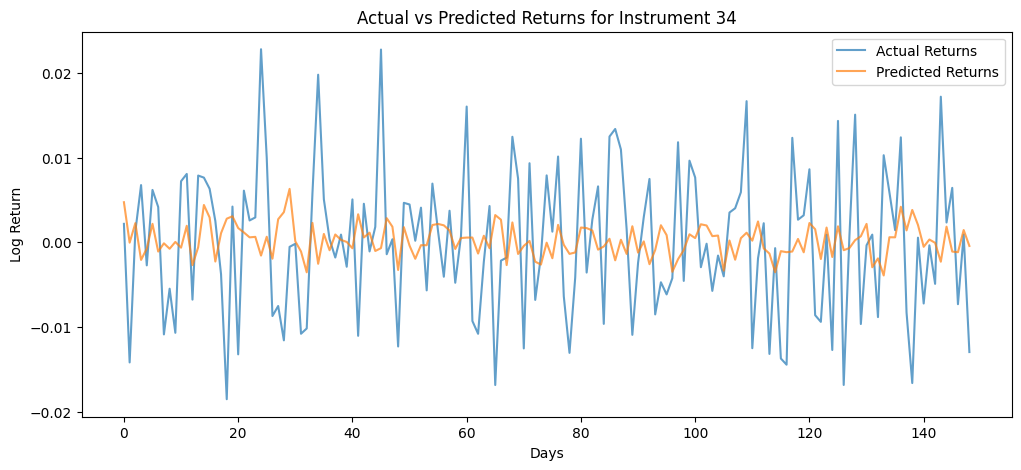

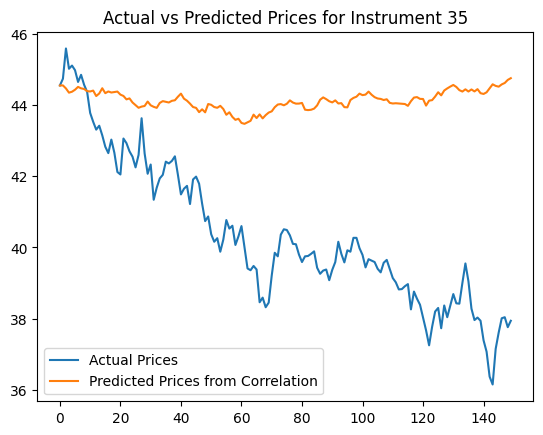

Evaluation for Instrument 35:
Mean Squared Error (MSE): 0.000101
Mean Absolute Error (MAE): 0.007854
R² Score: -0.0679


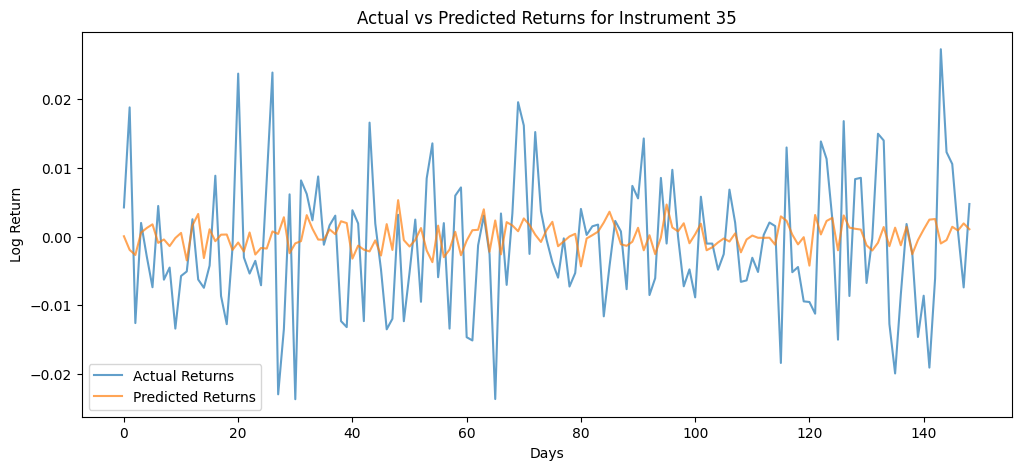

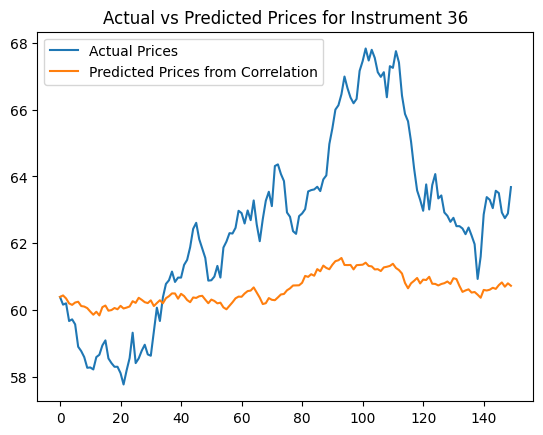

Evaluation for Instrument 36:
Mean Squared Error (MSE): 0.000052
Mean Absolute Error (MAE): 0.005638
R² Score: -0.0078


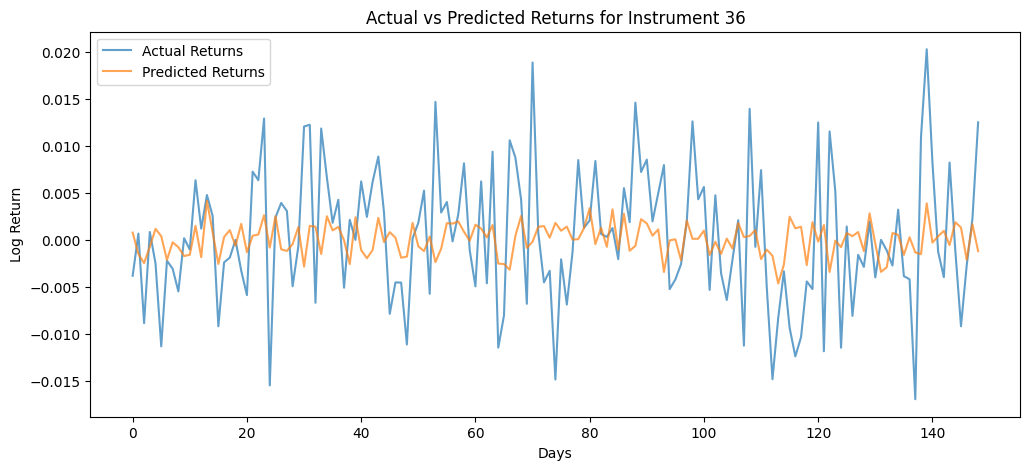

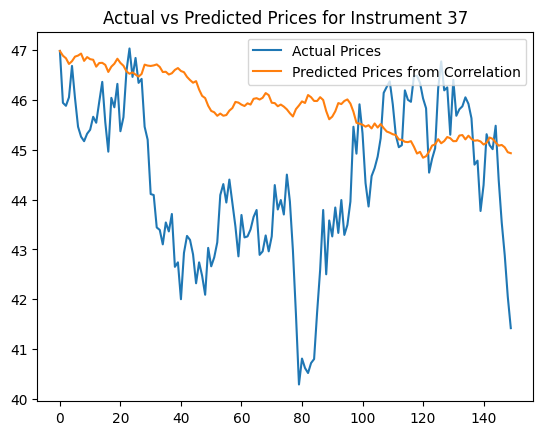

Evaluation for Instrument 37:
Mean Squared Error (MSE): 0.000202
Mean Absolute Error (MAE): 0.011395
R² Score: -0.0303


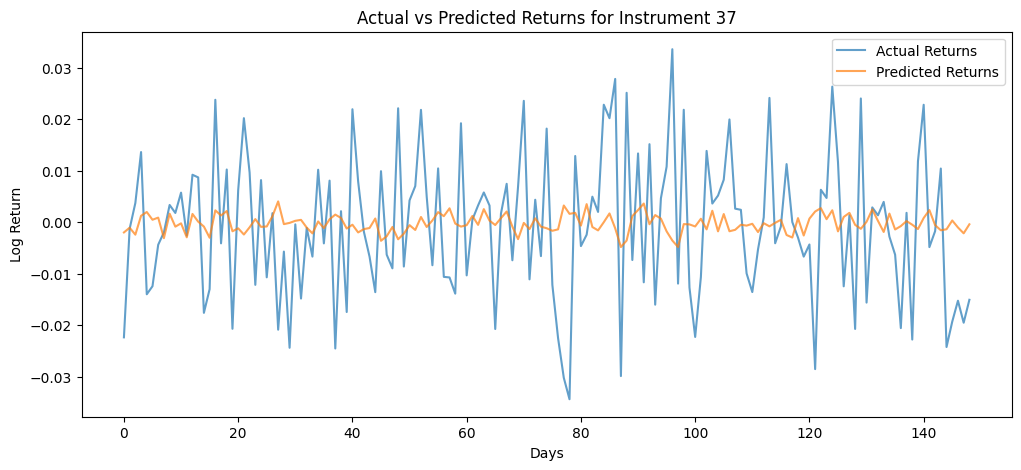

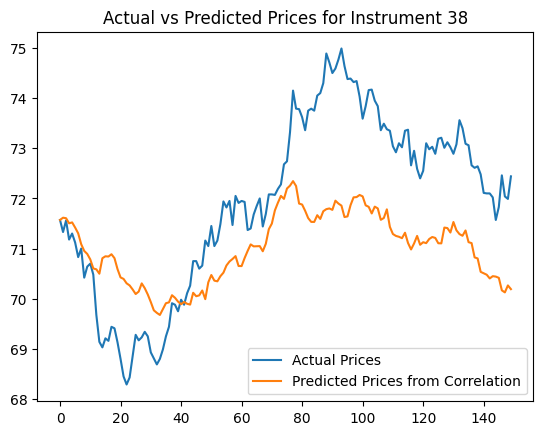

Evaluation for Instrument 38:
Mean Squared Error (MSE): 0.000017
Mean Absolute Error (MAE): 0.003333
R² Score: -0.0597


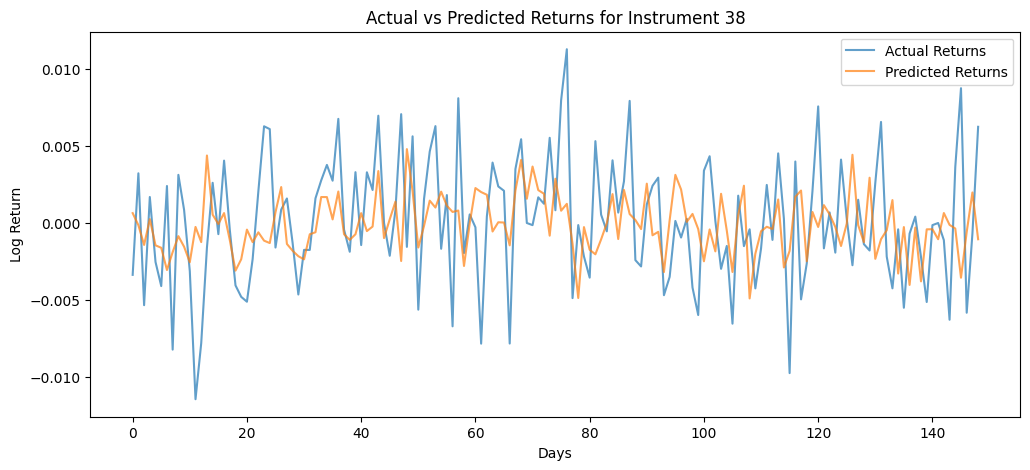

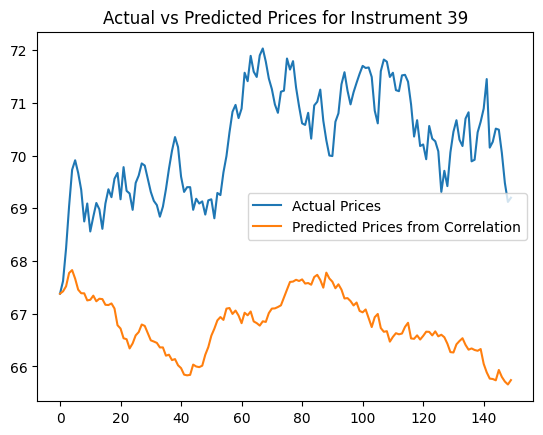

Evaluation for Instrument 39:
Mean Squared Error (MSE): 0.000031
Mean Absolute Error (MAE): 0.004490
R² Score: -0.0915


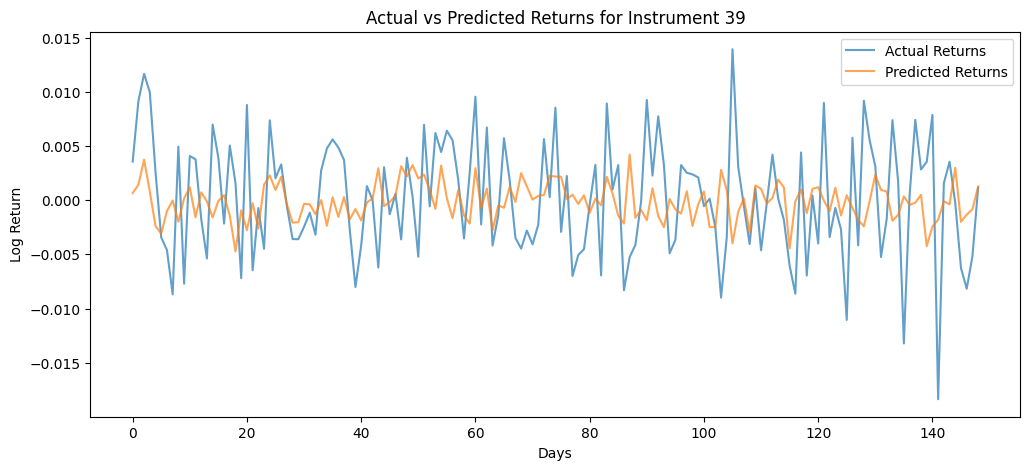

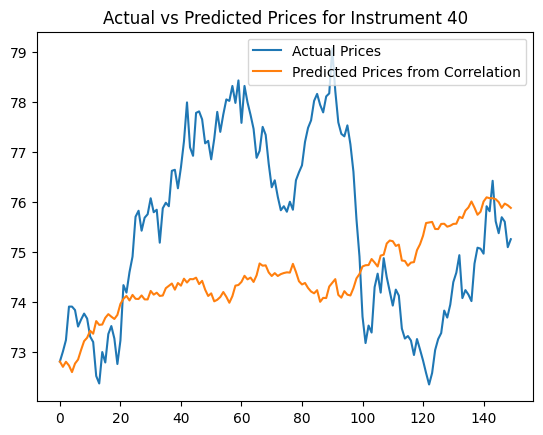

Evaluation for Instrument 40:
Mean Squared Error (MSE): 0.000038
Mean Absolute Error (MAE): 0.004996
R² Score: -0.1192


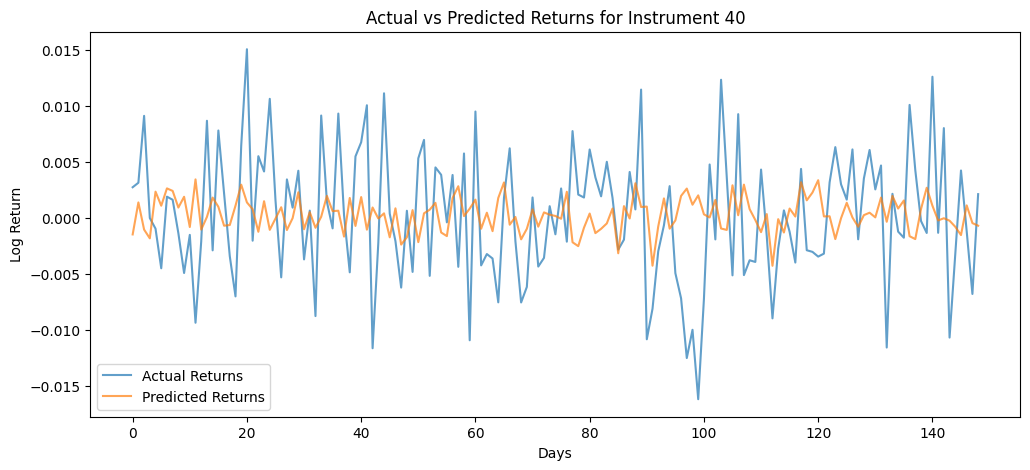

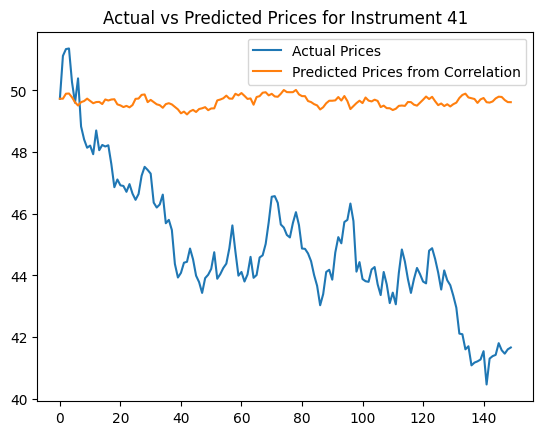

Evaluation for Instrument 41:
Mean Squared Error (MSE): 0.000132
Mean Absolute Error (MAE): 0.009051
R² Score: -0.0329


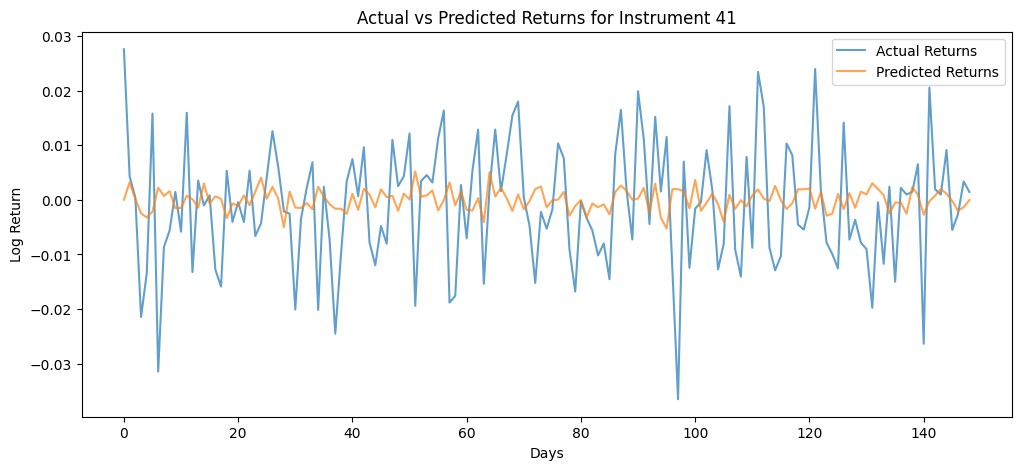

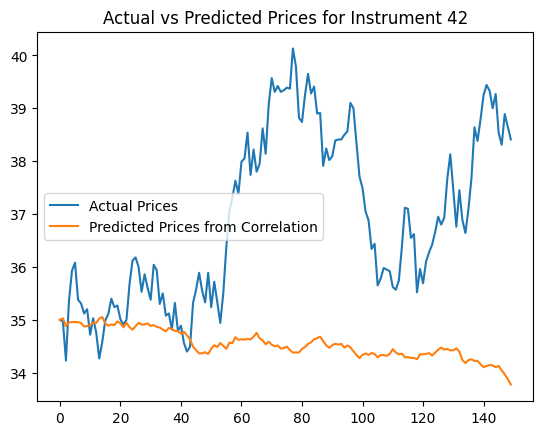

Evaluation for Instrument 42:
Mean Squared Error (MSE): 0.000147
Mean Absolute Error (MAE): 0.009754
R² Score: -0.0102


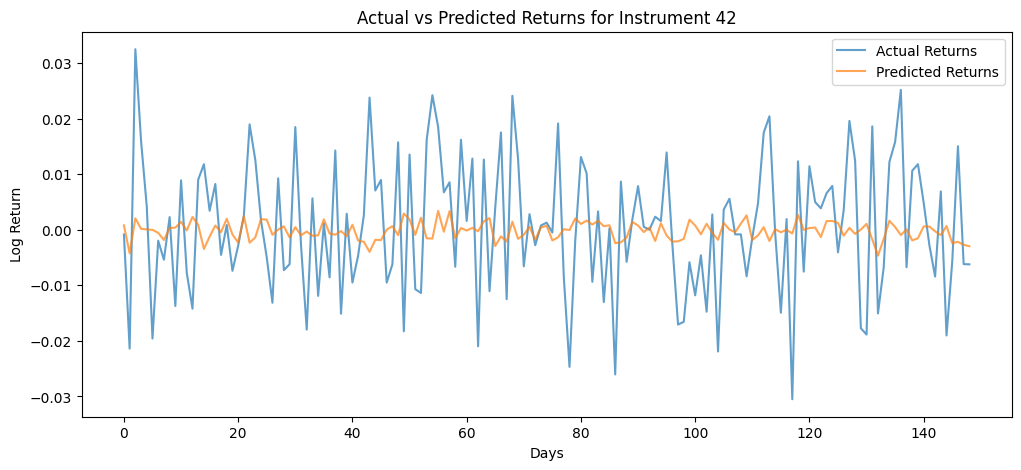

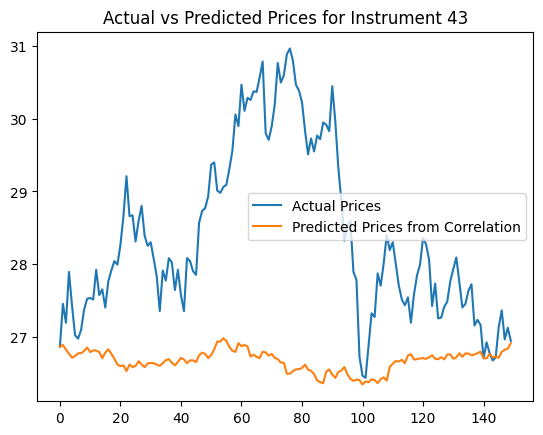

Evaluation for Instrument 43:
Mean Squared Error (MSE): 0.000148
Mean Absolute Error (MAE): 0.009787
R² Score: -0.0756


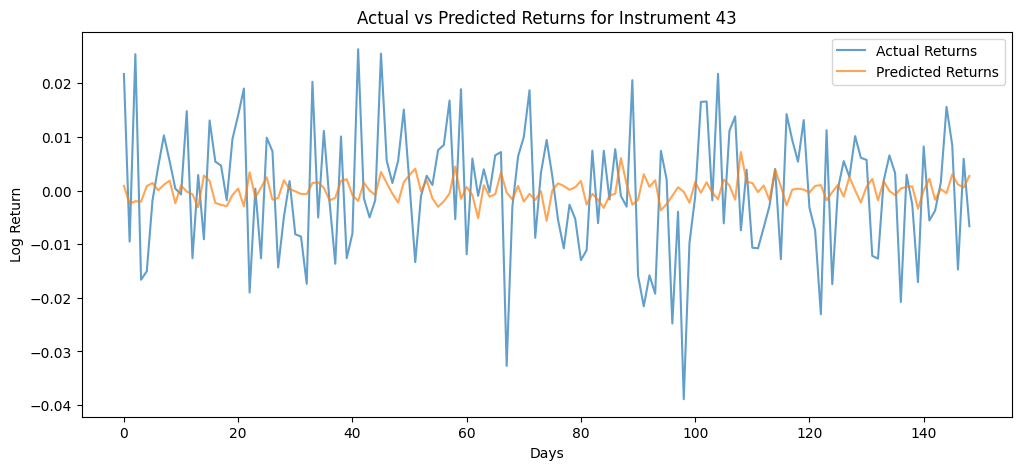

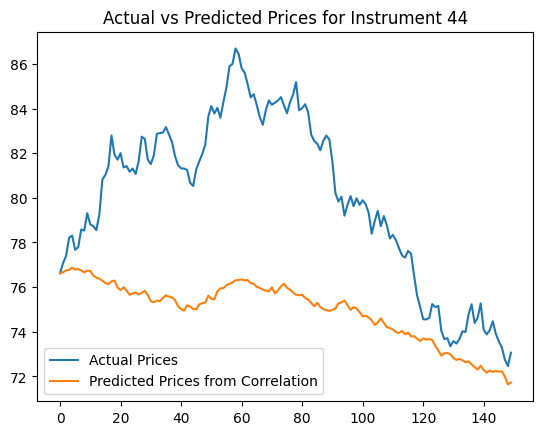

Evaluation for Instrument 44:
Mean Squared Error (MSE): 0.000044
Mean Absolute Error (MAE): 0.005326
R² Score: 0.0309


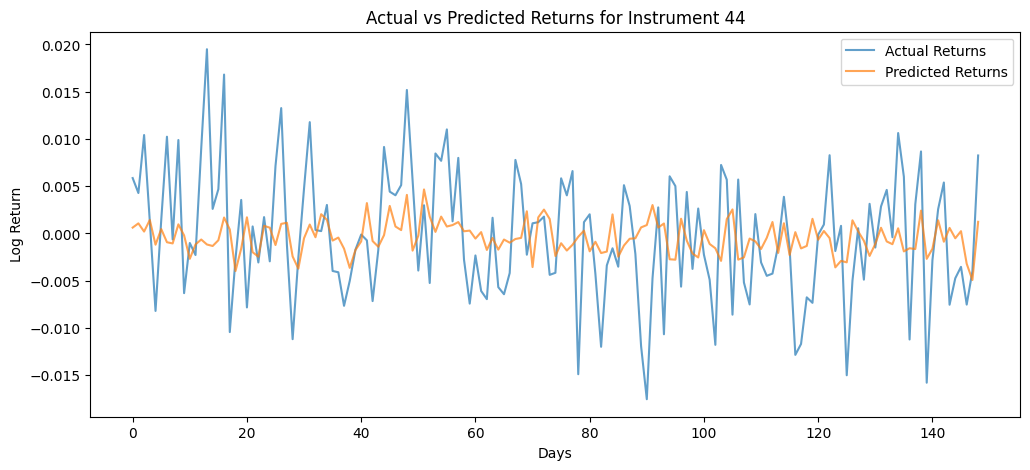

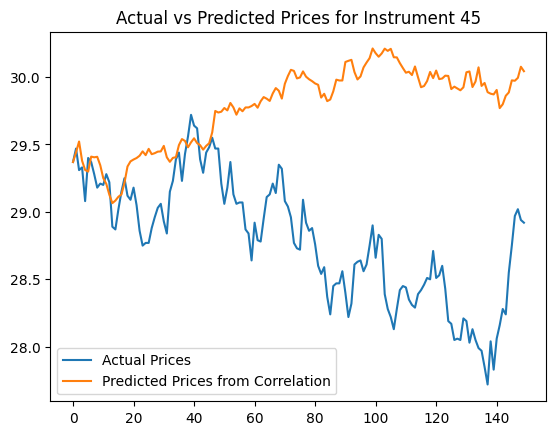

Evaluation for Instrument 45:
Mean Squared Error (MSE): 0.000029
Mean Absolute Error (MAE): 0.004352
R² Score: -0.1567


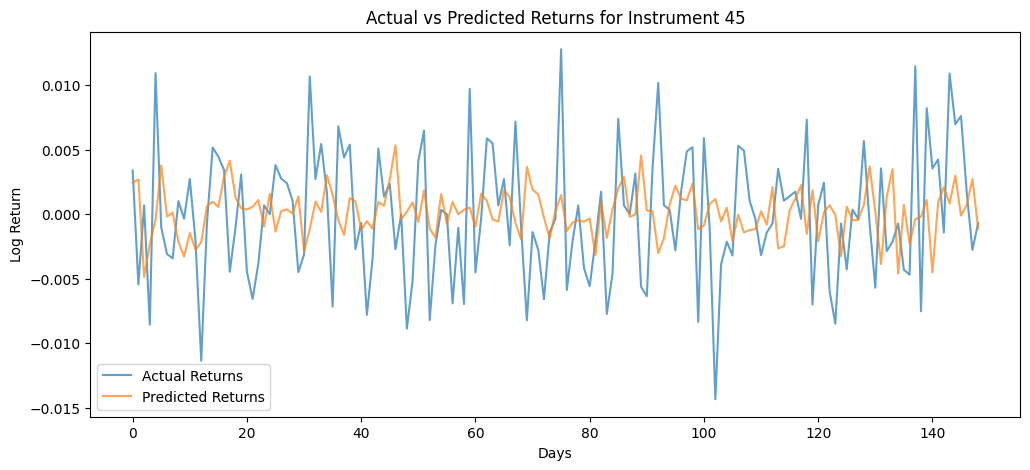

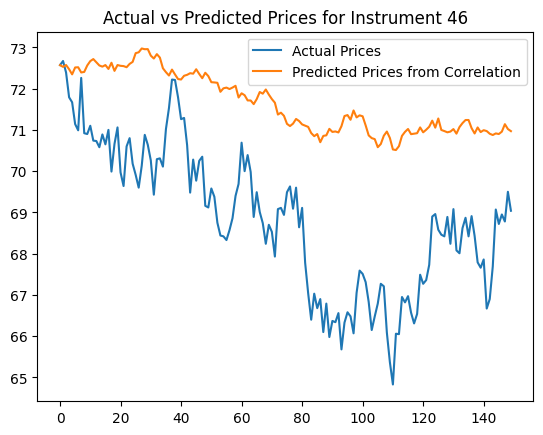

Evaluation for Instrument 46:
Mean Squared Error (MSE): 0.000078
Mean Absolute Error (MAE): 0.007172
R² Score: -0.0506


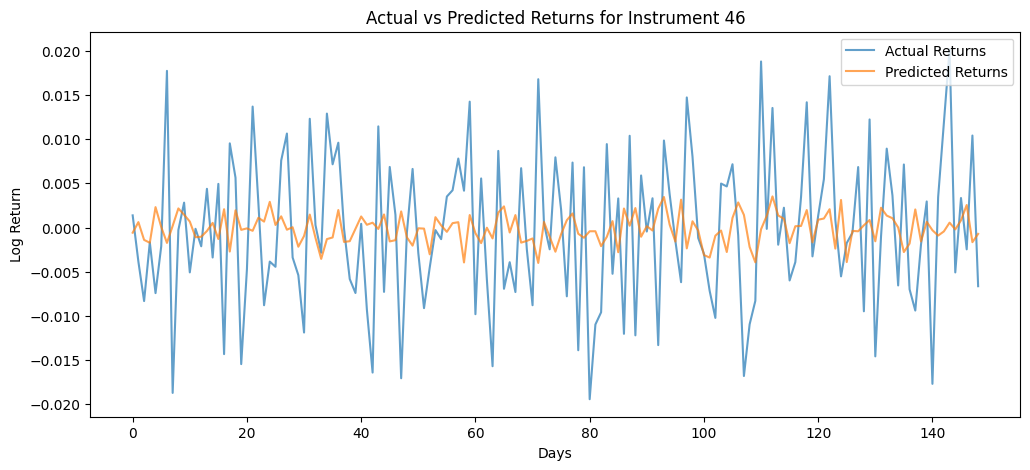

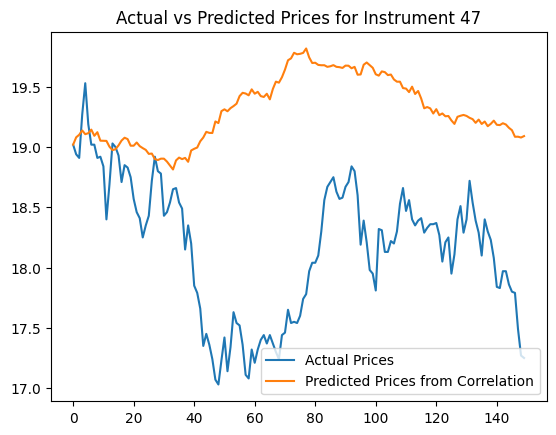

Evaluation for Instrument 47:
Mean Squared Error (MSE): 0.000090
Mean Absolute Error (MAE): 0.007575
R² Score: -0.0439


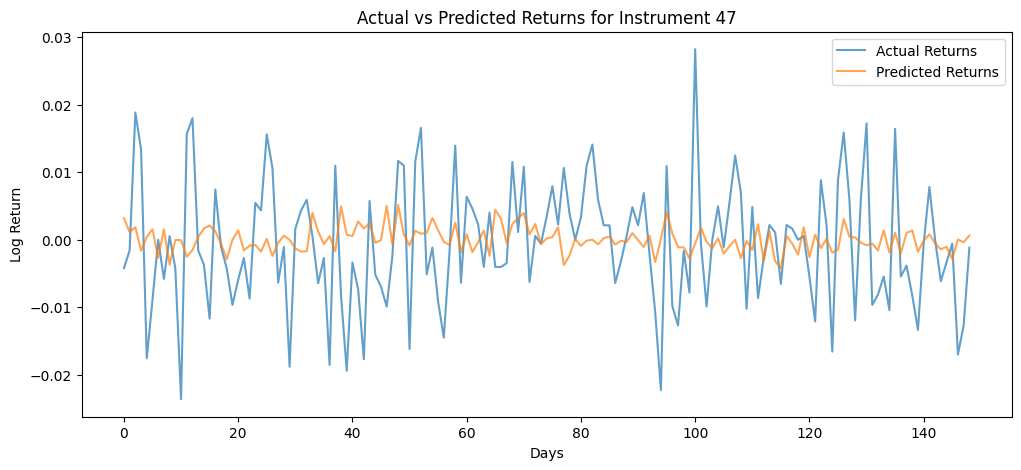

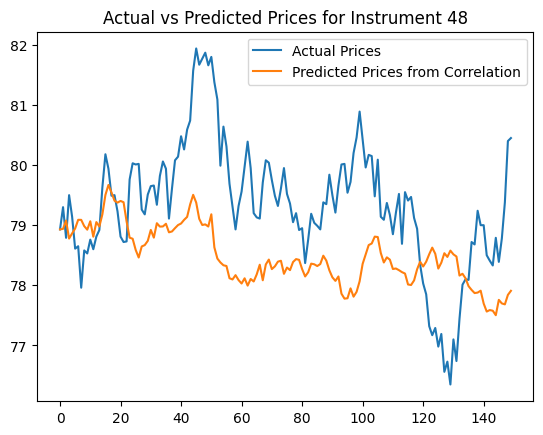

Evaluation for Instrument 48:
Mean Squared Error (MSE): 0.000032
Mean Absolute Error (MAE): 0.004510
R² Score: -0.1273


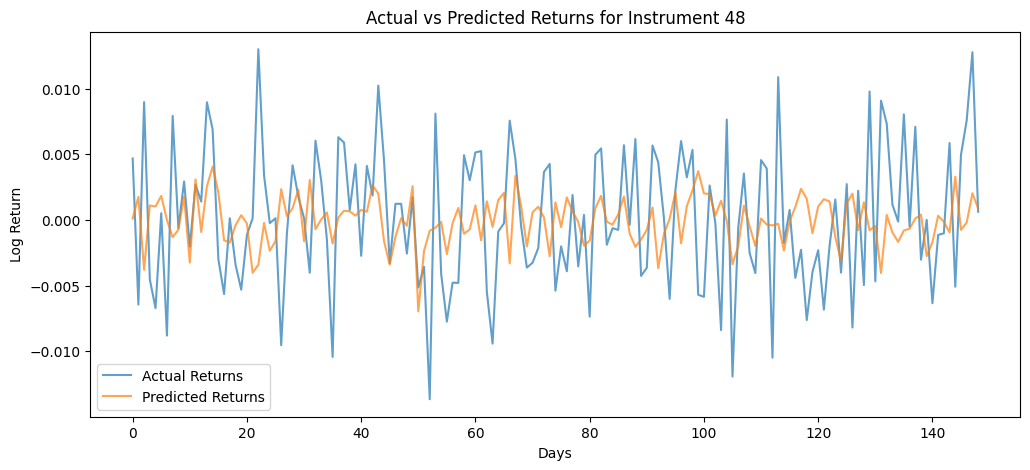

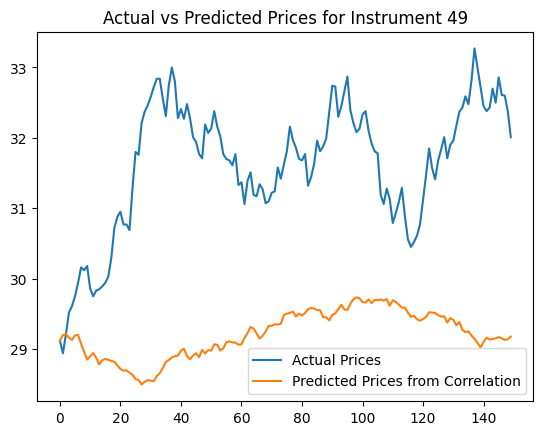

Evaluation for Instrument 49:
Mean Squared Error (MSE): 0.000064
Mean Absolute Error (MAE): 0.006595
R² Score: -0.1440


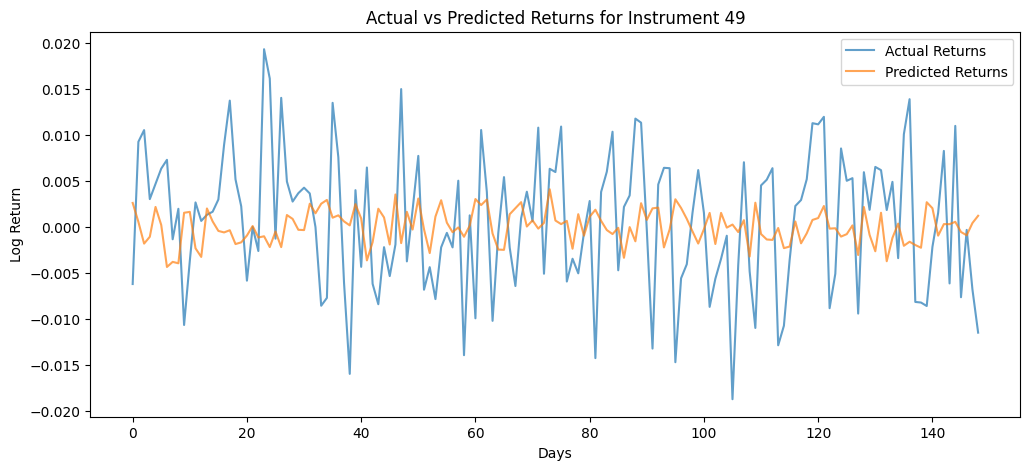

[-0.09700854929503322, -0.11337534357840195, -0.017955374236842125, -0.033298850485991016, -0.03673735499544262, -0.18104307909131867, -0.05129409222769188, -0.03892900590268278, -0.039327935073960374, -0.011597605114612941, -0.059044947263455994, -0.042798683117762915, -0.060927993594491525, -0.011361657942518644, -0.04660211632670164, -0.045835606614076596, -0.09676900296605462, -0.0038659837062529068, 0.0021463800558586543, -0.1081448421406308, -0.08702539424856526, -0.059807330283045745, -0.02185084326217468, -0.03414579722811251, -0.026721694913335314, -0.08535102224726598, -0.006426084131527343, -0.044702142615029805, -0.06220001656061358, -0.026813590763642425, -0.1596125642428956, -0.04218688614362476, 0.014335672969834401, -0.04831326207620412, -0.04011040280696032, -0.06785384696856522, -0.007844124209354542, -0.030314683865649394, -0.0597386913740392, -0.09148438010927507, -0.11920257100831955, -0.03287512462782449, -0.010175204676710736, -0.07563745381948417, 0.030915744727

In [42]:

def predict_instrument_returns(prc_matrix, corr_matrix, target_idx):
    """
    Predict the log returns of the target instrument as a weighted sum of
    other instruments' log returns, weighted by their correlation with the target.

    Parameters:
        prc_matrix (ndarray): shape (num_instruments, num_days), closing prices
        corr_matrix (ndarray): shape (num_instruments, num_instruments), correlation matrix of returns
        target_idx (int): index of the instrument to predict

    Returns:
        predicted_returns (ndarray): predicted log returns for the target instrument, shape (num_days-1,)
    """
    n = prc_matrix.shape[0]
    assert corr_matrix.shape == (n, n), "Correlation matrix shape mismatch"

    # Calculate log returns
    log_prices = np.log(prc_matrix)
    log_returns = np.diff(log_prices, axis=1)  # shape (n, num_days-1)

    # Get weights from correlation matrix, zero self-correlation
    weights = corr_matrix[target_idx].copy()
    weights[target_idx] = 0

    # Normalize weights by sum of absolute values to keep scale
    sum_weights = np.sum(np.abs(weights))
    if sum_weights != 0:
        weights /= sum_weights

    # Weighted sum of other instruments' returns to predict target returns
    predicted_returns = weights @ log_returns  # shape (num_days-1,)

    return predicted_returns


def reconstruct_price_from_returns(start_price, returns):
    """
    Reconstruct price series from starting price and log returns.

    Parameters:
        start_price (float): initial price before returns start
        returns (ndarray): log returns array shape (num_days-1,)

    Returns:
        prices (ndarray): reconstructed price series shape (num_days,)
    """
    cum_log_return = np.cumsum(returns)
    prices = start_price * np.exp(cum_log_return)
    prices = np.insert(prices, 0, start_price)  # include starting price
    return prices


def evaluate_predicted_returns(prc_matrix, predicted_returns, target_idx):
    """
    Compare predicted returns with actual returns and compute metrics.

    Parameters:
        prc_matrix (ndarray): (num_instruments, num_days) price matrix
        predicted_returns (ndarray): predicted log returns for target instrument, shape (num_days-1,)
        target_idx (int): index of the instrument being predicted

    Returns:
        metrics (dict): mse, mae, r2 scores
    """
    # Calculate actual log returns
    log_prices = np.log(prc_matrix)
    actual_returns = np.diff(log_prices[target_idx])

    # Metrics
    mse = mean_squared_error(actual_returns, predicted_returns)
    mae = mean_absolute_error(actual_returns, predicted_returns)
    r2 = r2_score(actual_returns, predicted_returns)

    print(f"Evaluation for Instrument {target_idx}:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.4f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(12, 5))
    plt.plot(actual_returns, label='Actual Returns', alpha=0.7)
    plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
    plt.title(f'Actual vs Predicted Returns for Instrument {target_idx}')
    plt.xlabel('Days')
    plt.ylabel('Log Return')
    plt.legend()
    plt.show()

    return {'mse': mse, 'mae': mae, 'r2': r2}
r2 = list()

data = prcCheck
for target_idx in range(50):
    predicted_ret = predict_instrument_returns(data, corr_matrix, target_idx)

    # Reconstruct predicted prices starting from actual first price
    predicted_prices = reconstruct_price_from_returns(data[target_idx, 0], predicted_ret)

    plt.plot(data[target_idx], label="Actual Prices")
    plt.plot(predicted_prices, label="Predicted Prices from Correlation")
    plt.legend()
    plt.title(f"Actual vs Predicted Prices for Instrument {target_idx}")
    plt.show()
    predicted_ret = predict_instrument_returns(data, corr_matrix, target_idx)
    metrics = evaluate_predicted_returns(data, predicted_ret, target_idx)
    r2.append(metrics['r2'])
print(r2)
    

In [ ]:
def top_n_with_indices(arr, n=5):
    arr = np.array(arr)
    # Get indices of top n values
    top_indices = np.argsort(arr)[-n:][::-1]
    top_values = arr[top_indices]
    return list(zip(top_indices, top_values))
top5 = top_n_with_indices(r2, 5)

[(np.int64(36), np.float64(0.02292765371386618)), (np.int64(8), np.float64(0.021728679357068792)), (np.int64(9), np.float64(0.016182041423653426)), (np.int64(34), np.float64(0.012879005631909468)), (np.int64(33), np.float64(0.012239747784367094))]
-0.020797008131451022
